In [1]:
!pwd

/users/edolores/TOOLS/HW_contrack


In [2]:
from pyproj import Proj, Transformer, transform, CRS
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cf
#import xesmf as xe
import matplotlib.patches as mpatches
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import glob
import os
import pandas as pd
import time
from itertools import groupby
from scipy.stats import linregress
from scipy import ndimage
from contrack import contrack
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader
import shapely
import shapely.ops as sops
import shapely.vectorized as sv

# My functions live in climate_indices.py in the same folder:
from utils.hw_climate_indices import (
    count_frost_days, count_summer_days, count_icing_days,
    compute_dtr, compute_CDD, compute_CWD, compute_precip_exceedance, get_trend
)

# My functions live in HW_Russo_exclaim.py in the same folder:
from utils.HW_Russo_exclaim import (
    drop_feb29, dayofyear_365, circular_day_distance,
    compute_tr90d, label_runs_1d, run_lengths_from_labels_1d,
    detect_heatwaves,_season_masks_from_profile, split_heatwaves_by_season,
    _events_full_len_assign_season,durations_full_event_per_season_year,
    make_land_mask_like, make_land_mask
)

from utils.data_harmony import preprocess

In [3]:
####

In [4]:
### Save project figures
dir_figures='/users/edolores/TOOLS/HW_contrack/figures/'

# Basic plots

In [4]:
### We load 2 m tempearture daily mean data for the Northern hemisphere 

In [5]:
#da=xr.open_mfdataset('/capstor/scratch/cscs/edolores/OBS/ERA5/TS_era5/t2m_day_*_0p5deg.nc')['t2m']
da=xr.open_mfdataset('/capstor/scratch/cscs/edolores/OBS/ERA5/TS_era5/SH/t2m_day_*_0p5deg.nc',preprocess=preprocess,combine="by_coords")['t2m']
da

<xarray.DataArray 't2m' (time: 24107, lat: 181, lon: 720)> Size: 13GB
dask.array<concatenate, shape=(24107, 181, 720), dtype=float32, chunksize=(366, 181, 720), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 193kB 1959-01-01T11:00:00 ... 2024-12-31T1...
  * lon      (lon) float32 3kB -180.0 -179.5 -179.0 -178.5 ... 178.5 179.0 179.5
  * lat      (lat) float32 724B -90.0 -89.5 -89.0 -88.5 ... -1.5 -1.0 -0.5 0.0
Attributes:
    long_name:     2 metre temperature
    units:         K
    cell_methods:  time: mean
    institution:   ECMWF

In [48]:
### NH mean time series from monthly data
ds1=xr.open_dataset('/capstor/scratch/cscs/edolores/OBS/ERA5/TS_era5/t2m_mon.nc')['t2m']
ds2=xr.open_dataset('/capstor/scratch/cscs/edolores/OBS/ERA5/TS_era5/SH/t2m_mon.nc')['t2m']

# If ds1 covers -90 to 0 and ds2 covers 0 to 90 in latitude
era5_month = xr.concat([ds1, ds2], dim='lat')
era5_month=era5_month.sortby('lat')
era5_month

### from daily data
#era5_month=da.resample(time='1M').mean()

/users/edolores/.env_icon/lib/python3.12/site-packages/xarray/coding/times.py:365: CFWarning: this date/calendar/year zero convention is not supported by CF
  cftime.num2date(num_dates, units, calendar, only_use_cftime_datetimes=True)
/tmp/ipykernel_113248/987764305.py:2: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates prior reform date (1582-10-15). To silence this warning specify 'use_cftime=True'.
  ds1=xr.open_dataset('/capstor/scratch/cscs/edolores/OBS/ERA5/TS_era5/t2m_mon.nc')['t2m']


<xarray.DataArray 't2m' (time: 792, lat: 362, lon: 720)> Size: 826MB
array([[[244.6983 , 244.6983 , 244.6983 , ..., 244.6983 , 244.6983 ,
         244.6983 ],
        [243.85645, 243.8651 , 243.87372, ..., 243.83087, 243.83934,
         243.84789],
        [243.06737, 243.08397, 243.10071, ..., 243.01913, 243.03503,
         243.0512 ],
        ...,
        [244.93182, 244.92613, 244.9203 , ..., 244.93431, 244.93352,
         244.93272],
        [244.65283, 244.65106, 244.64929, ..., 244.65802, 244.65634,
         244.6546 ],
        [244.40768, 244.40768, 244.40768, ..., 244.40768, 244.40768,
         244.40768]],

       [[237.6492 , 237.6492 , 237.6492 , ..., 237.6492 , 237.6492 ,
         237.6492 ],
        [236.89946, 236.9052 , 236.91106, ..., 236.88249, 236.88806,
         236.8937 ],
        [236.10425, 236.11583, 236.12755, ..., 236.058  , 236.07335,
         236.08876],
...
        [256.30356, 256.31046, 256.31747, ..., 256.2793 , 256.2873 ,
         256.29538],
        [256.70038, 256.70242, 256.7045 , ..., 256.69437, 256.69632,
         256.69833],
        [256.85455, 256.85455, 256.85455, ..., 256.85455, 256.85455,
         256.85455]],

       [[244.52704, 244.52704, 244.52704, ..., 244.52704, 244.52704,
         244.52704],
        [244.23463, 244.24178, 244.24886, ..., 244.21352, 244.22055,
         244.2276 ],
        [243.90042, 243.91452, 243.92867, ..., 243.87071, 243.88058,
         243.89047],
        ...,
        [250.35063, 250.34268, 250.33475, ..., 250.36385, 250.35944,
         250.35504],
        [250.35262, 250.34946, 250.3463 , ..., 250.36203, 250.35889,
         250.35576],
        [250.49556, 250.49556, 250.49556, ..., 250.49556, 250.49556,
         250.49556]]], shape=(792, 362, 720), dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 6kB 1959-01-16T11:00:00 ... 2024-12-16T11:...
  * lon      (lon) float32 3kB -180.0 -179.5 -179.0 -178.5 ... 178.5 179.0 179.5
  * lat      (lat) float32 1kB -90.0 -89.5 -89.0 -88.5 ... 88.5 89.0 89.5 90.0
Attributes:
    long_name:     2 metre temperature
    units:         K
    cell_methods:  time: mean
    institution:   ECMWF

In [43]:
era5_month_mean = era5_month.mean(dim=["lat", "lon"]) #.compute()

# >>> Key change: ensure time chunks are >= 12
era5_month_mean = era5_month_mean.chunk({'time': 120})

# 12-month (1 year) rolling mean
#the window length (rolling(time=N)) depending on how much smoothing you want (e.g., 6 for half-year, 24 for 2 years).
era5_smooth = era5_month_mean.rolling(time=12, center=True).mean() #.compute()


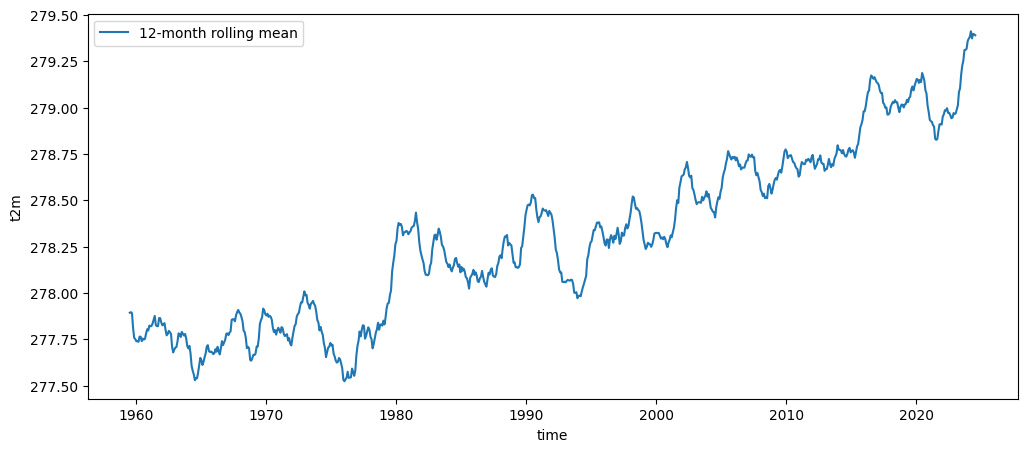

In [44]:
# Plot both raw monthly and smoothed
plt.figure(figsize=(12,5))
#era5_month_mean.plot(label="Monthly mean")
era5_smooth.plot(label="12-month rolling mean")
plt.legend()
plt.show()

In [45]:
### NH map mean

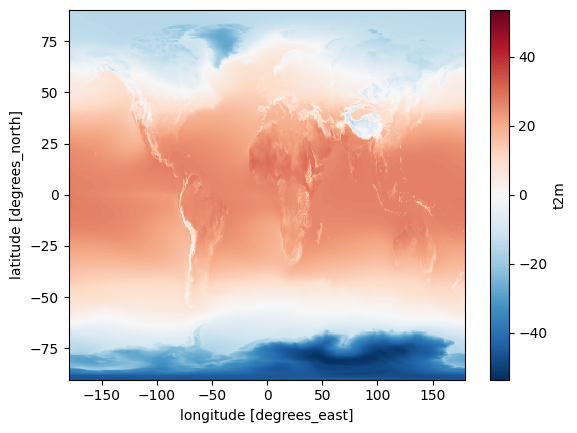

In [46]:
(era5_month-273.15).mean(dim=['time']).plot()

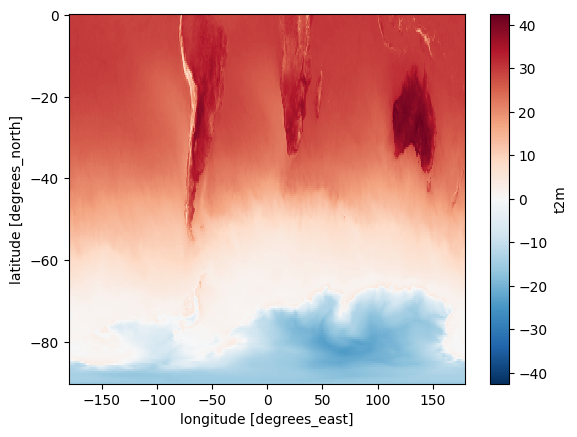

In [47]:
### max daily mean
(da-273.15).max(dim=['time']).plot()

In [17]:
### mean yearly
temp_year=era5_month.resample(time='1Y').mean()
temp_year
# Convert time to float years
time_in_years = temp_year['time'].dt.year + (temp_year['time'].dt.dayofyear - 1) / 365.25
print(time_in_years)

results = xr.apply_ufunc(
    get_trend,
    time_in_years, temp_year.compute(),
#    temp_year['time'], temp_year,
    input_core_dims=[['time'], ['time']],
    output_core_dims=[[], [], []],
    vectorize=True,
)


ds = xr.Dataset(
    {'slope': results[0],
     'intercept': results[1],
     'pvalue': results[2],
    })
ds

<xarray.DataArray (time: 41)>
array([1959.99657769, 1960.99931554, 1961.99657769, 1962.99657769,
       1963.99657769, 1964.99931554, 1965.99657769, 1966.99657769,
       1967.99657769, 1968.99931554, 1969.99657769, 1970.99657769,
       1971.99657769, 1972.99931554, 1973.99657769, 1974.99657769,
       1975.99657769, 1976.99931554, 1977.99657769, 1978.99657769,
       1979.99657769, 1980.99931554, 1981.99657769, 1982.99657769,
       1983.99657769, 1984.99931554, 1985.99657769, 1986.99657769,
       1987.99657769, 1988.99931554, 1989.99657769, 1990.99657769,
       1991.99657769, 1992.99931554, 1993.99657769, 1994.99657769,
       1995.99657769, 1996.99931554, 1997.99657769, 1998.99657769,
       1999.99657769])
Coordinates:
  * time     (time) datetime64[ns] 1959-12-31 1960-12-31 ... 1999-12-31


<xarray.Dataset>
Dimensions:    (lon: 720, lat: 181)
Coordinates:
  * lon        (lon) float32 -180.0 -179.5 -179.0 -178.5 ... 178.5 179.0 179.5
  * lat        (lat) float32 0.0 0.5 1.0 1.5 2.0 ... 88.0 88.5 89.0 89.5 90.0
Data variables:
    slope      (lat, lon) float64 0.006858 0.006743 0.006496 ... 0.06807 0.06807
    intercept  (lat, lon) float64 286.4 286.6 287.1 287.6 ... 123.0 123.0 123.0
    pvalue     (lat, lon) float64 0.08074 0.08823 ... 4.673e-06 4.673e-06

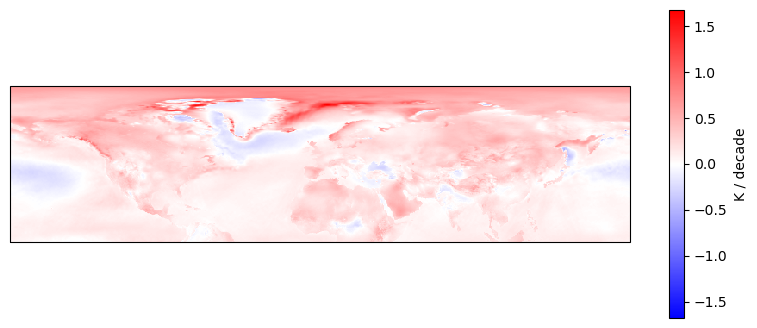

In [18]:
fig, ax = plt.subplots(figsize=(10, 4), subplot_kw={'projection': ccrs.PlateCarree()})
(ds['slope'] * 10).plot.pcolormesh(ax=ax, cmap='bwr', cbar_kwargs={'label': 'K / decade'})

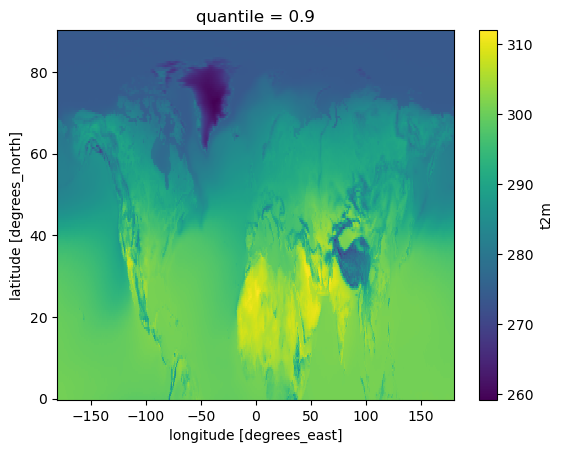

In [19]:
### percentiles
ds1 = da.chunk({"time": -1})
q90 = ds1.quantile(0.9, dim="time")
q90.plot()

In [20]:
### Mask to count days above the 20 (tropical nights) --> This should be minimum temperature
temp_mask = ((da-273.15) > 20).compute() # gives true and false values (which is our mask)
#temp_mask.compute()

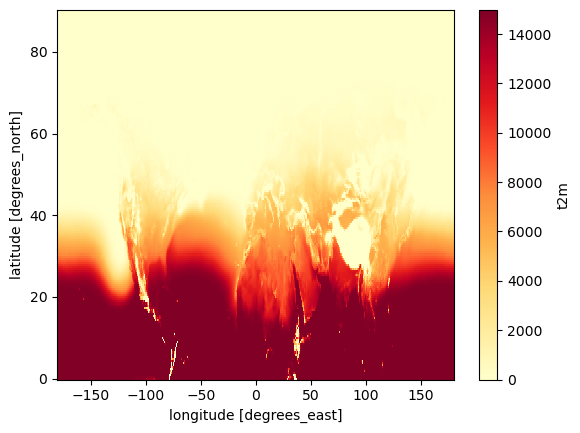

In [21]:
# Counting the days and plotting
temp_mask.sum(dim=["time"]).plot(
    cmap='YlOrRd'#, levels=np.arange(0, 200, 20)
)  # Sum up True values and plot the result

# Traditional heatwave identification

In [30]:
##tmax

In [6]:
## NH
tmax=xr.open_mfdataset('/capstor/scratch/cscs/edolores/OBS/ERA5/TMAX_era5/tmax_day_*_0p5deg.nc',{"time": 366, "lat": 181, "lon": 720})['t2m']
## SH
#tmax =xr.open_mfdataset('/capstor/scratch/cscs/edolores/OBS/ERA5/TS_era5/SH/t2m_day_*_0p5deg.nc',{"time": 366, "lat": 181, "lon": 720},preprocess=preprocess,combine="by_coords")['t2m']
#tmax

/tmp/ipykernel_6111/2385166902.py:2: FutureWarning: In a future version of xarray the default value for join will change from join='outer' to join='exact'. This change will result in the following ValueError: cannot be aligned with join='exact' because index/labels/sizes are not equal along these coordinates (dimensions): 'time' ('time',) The recommendation is to set join explicitly for this case.
  tmax=xr.open_mfdataset('/capstor/scratch/cscs/edolores/OBS/ERA5/TMAX_era5/tmax_day_*_0p5deg.nc',{"time": 366, "lat": 181, "lon": 720})['t2m']
/tmp/ipykernel_6111/2385166902.py:2: FutureWarning: In a future version of xarray the default value for compat will change from compat='no_conflicts' to compat='override'. This is likely to lead to different results when combining overlapping variables with the same name. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set compat explicitly.
  tmax=xr.open_mfdataset('/capstor/scratch

In [9]:
# ----------------------------
# Main pipeline
# ----------------------------
# 1a) Compute Tr90d on 1961–1990 (±15 days => 31-day window)
tr90d = compute_tr90d(tmax, ref_start="1961-01-01", ref_end="1990-12-31",
                      window_halfwidth=15, q=0.90)

# 1b) Compute Tr90d on 2020–2024 (±15 days => 31-day window) (own climatology)
#tr90d = compute_tr90d(tmax, ref_start="2020-01-20", ref_end="2024-04-01",
#                      window_halfwidth=15, q=0.90)

## open climatology created
###
#tr90d=xr.open_dataset('/capstor/scratch/cscs/edolores/OBS/ERA5/Heatwaves/Russo/TR90d_1961_1990.nc')['Tr90d']
#tr90d#.isel(dayofyear=100).plot()

In [10]:
###

In [11]:
### select a smaller time period [this is simlar to the simulation]
#tmax=tmax.sel(time=slice('2020-01-20','2024-04-01'))

# 2) Detect heatwaves across the full record (1959–2023)
hw_mask, hot_mask, tr_full = detect_heatwaves(tmax, tr90d, min_duration=3)

In [23]:
### plot any timestep
#hw_mask.sel(time='2020-06-30').plot()
#hot_mask.sel(time='2020-06-30').plot()
#tr_full.sel(time='2020-06-30').plot()
### saving
first_year=str(hw_mask['time'].isel(time=0).dt.year.item())
last_year=str(hw_mask['time'].isel(time=-1).dt.year.item())
print(first_year, last_year)
#NH
#hw_mask.to_netcdf('/capstor/scratch/cscs/edolores/OBS/ERA5/Heatwaves/Russo/hw_mask_'+first_year+'-'+last_year+'.nc')
#hot_mask.to_netcdf('/capstor/scratch/cscs/edolores/OBS/ERA5/Heatwaves/Russo/hot_mask_'+first_year+'-'+last_year+'.nc')
#tr_full.to_netcdf('/capstor/scratch/cscs/edolores/OBS/ERA5/Heatwaves/Russo/tr_full_'+first_year+'-'+last_year+'.nc')
#SH
#hw_mask.to_netcdf('/capstor/scratch/cscs/edolores/OBS/ERA5/Heatwaves/Russo/SH/hw_mask_2020-2024.nc')
#hot_mask.to_netcdf('/capstor/scratch/cscs/edolores/OBS/ERA5/Heatwaves/Russo/SH/hot_mask_2020-2024.nc')
#tr_full.to_netcdf('/capstor/scratch/cscs/edolores/OBS/ERA5/Heatwaves/Russo/SH/tr_full_2020-2024.nc')

###opening saved data
#hw_mask=xr.open_dataset('/capstor/scratch/cscs/edolores/OBS/ERA5/Heatwaves/Russo/hw_mask.nc')['heatwave_day']
#hot_mask=xr.open_dataset('/capstor/scratch/cscs/edolores/OBS/ERA5/Heatwaves/Russo/hot_mask.nc')['hot_day']
#tr_full=xr.open_dataset('/capstor/scratch/cscs/edolores/OBS/ERA5/Heatwaves/Russo/tr_full.nc')['Tr90d']
#SH
#hw_mask=xr.open_dataset('/capstor/scratch/cscs/edolores/OBS/ERA5/Heatwaves/Russo/SH/hw_mask_2020-2024.nc')['heatwave_day']
#hot_mask=xr.open_dataset('/capstor/scratch/cscs/edolores/OBS/ERA5/Heatwaves/Russo/SH/hot_mask_2020-2024.nc')['hot_day']
#tr_full=xr.open_dataset('/capstor/scratch/cscs/edolores/OBS/ERA5/Heatwaves/Russo/SH/tr_full_2020-2024.nc')['Tr90d']

1959 2024


## Optional: yearly diagnostics

In [70]:
# Use the no-leap time axis to match hw_mask
t_noleap = drop_feb29(tmax)

# (a) number of heatwave days per year
hw_days_per_year = hw_mask.resample(time="YS").sum("time")
hw_days_per_year.name = "heatwave_days"

hw_days_per_year

<xarray.DataArray 'heatwave_days' (time: 5, lat: 181, lon: 720)> Size: 5MB
dask.array<stack, shape=(5, 181, 720), dtype=int64, chunksize=(1, 181, 720), chunktype=numpy.ndarray>
Coordinates:
  * lon       (lon) float32 3kB -180.0 -179.5 -179.0 ... 178.5 179.0 179.5
  * lat       (lat) float32 724B -90.0 -89.5 -89.0 -88.5 ... -1.5 -1.0 -0.5 0.0
    quantile  float64 8B 0.9
  * time      (time) datetime64[ns] 40B 2020-01-01 2021-01-01 ... 2024-01-01

In [59]:
### full dataset
mean_hw_days=hw_days_per_year.mean(dim='time') #.plot()#levels=np.arange(0,30,3))
### last 23 years
#mean_hw_days=hw_days_per_year.sel(time=slice('2000','2024')).mean(dim='time') 
## only last years
#mean_hw_days=hw_days_per_year.sel(time=slice('2020','2024')).mean(dim='time') 

In [60]:
###full plot 
'''
proj = ccrs.Robinson(central_longitude=0, globe=None)

fig, ax1 = plt.subplots(1, 1, figsize=(8, 6), dpi=100, subplot_kw={'projection': proj})
plot=mean_hw_days.plot(ax=ax1, cmap='YlOrRd', levels=np.arange(0,200,20),transform=ccrs.PlateCarree(),extend="max",cbar_kwargs={"orientation":"horizontal"})
# Add features
ax1.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', 
                                            edgecolor='face', facecolor='grey', alpha=0.30), zorder=20)
'''

'\nproj = ccrs.Robinson(central_longitude=0, globe=None)\n\nfig, ax1 = plt.subplots(1, 1, figsize=(8, 6), dpi=100, subplot_kw={\'projection\': proj})\nplot=mean_hw_days.plot(ax=ax1, cmap=\'YlOrRd\', levels=np.arange(0,200,20),transform=ccrs.PlateCarree(),extend="max",cbar_kwargs={"orientation":"horizontal"})\n# Add features\nax1.add_feature(cfeature.NaturalEarthFeature(\'physical\', \'land\', \'50m\', \n                                            edgecolor=\'face\', facecolor=\'grey\', alpha=0.30), zorder=20)\n'

In [63]:
## masking ocean

/tmp/ipykernel_113248/1753072218.py:23: DeprecationWarning: The 'shapely.vectorized.contains' function is deprecated and will be removed a future version. Use 'shapely.contains_xy' instead (available since shapely 2.0.0).
  mask_np |= sv.contains(g, xv, yv)


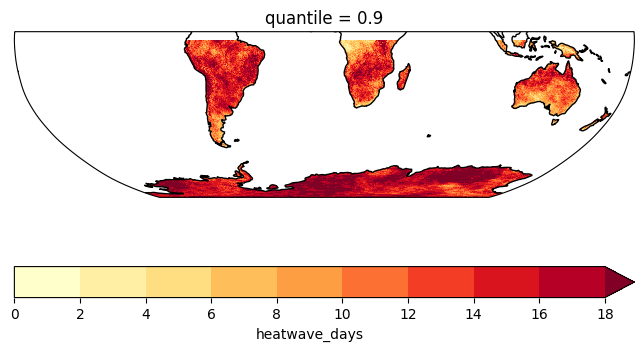

In [64]:
# --- names of coords ---
lat_name = next(n for n in mean_hw_days.coords if n.lower().startswith('lat'))
lon_name = next(n for n in mean_hw_days.coords if n.lower().startswith('lon'))

# --- 2D lon/lat matching your DataArray's grid & dim order ---
# These come back with dims ordered consistently (use them!)
lon2d, lat2d = xr.broadcast(mean_hw_days[lon_name], mean_hw_days[lat_name])

# Wrap to [-180, 180] for polygon tests
lon_wrapped = ((lon2d + 180) % 360) - 180

# --- Read Natural Earth land polygons (path -> Reader -> geometries) ---
shapefile = shpreader.natural_earth(resolution='110m', category='physical', name='land')
reader = shpreader.Reader(shapefile)
geoms = list(reader.geometries())

# --- Build mask with EXACTLY the same dims/coords as lon2d/lat2d ---
mask_np = np.zeros(lon2d.shape, dtype=bool)
# Use .values so shapely gets numpy arrays
xv = lon_wrapped.values
yv = lat2d.values
for g in geoms:
    mask_np |= sv.contains(g, xv, yv)

mask_da = xr.DataArray(
    mask_np,
    coords={lat_name: lat2d[lat_name], lon_name: lon2d[lon_name]},
    dims=lat2d.dims,  # keep the same dim order as broadcast gave us
)

# If your field has extra dims (e.g., time), broadcast mask to match
mask_da, _ = xr.broadcast(mask_da, mean_hw_days)

# --- Apply mask & plot ---
mean_hw_days_land = mean_hw_days.where(mask_da)

proj = ccrs.Robinson(central_longitude=0)
fig, ax1 = plt.subplots(1, 1, figsize=(8, 6), dpi=100, subplot_kw={'projection': proj})

plot = mean_hw_days_land.plot(
    ax=ax1,
    cmap='YlOrRd',
    levels=np.arange(0, 20, 2),
    transform=ccrs.PlateCarree(),
    extend="max",
    cbar_kwargs={"orientation": "horizontal"}
)
ax1.coastlines()

In [67]:
## We aim to create a time serie to compare with ICON simulations with a land mask

In [71]:
#hw_days_per_year.sel(time=slice('2020','2023')).sum(dim=['lat','lon']).plot()
#hw_days_per_year.sum(dim=['lat','lon']).plot()
hw_days_land = hw_days_per_year.where(mask_da)
hw_days_land

<xarray.DataArray 'heatwave_days' (time: 5, lat: 181, lon: 720)> Size: 5MB
dask.array<where, shape=(5, 181, 720), dtype=float64, chunksize=(1, 181, 720), chunktype=numpy.ndarray>
Coordinates:
  * lon       (lon) float32 3kB -180.0 -179.5 -179.0 ... 178.5 179.0 179.5
  * lat       (lat) float32 724B -90.0 -89.5 -89.0 -88.5 ... -1.5 -1.0 -0.5 0.0
    quantile  float64 8B 0.9
  * time      (time) datetime64[ns] 40B 2020-01-01 2021-01-01 ... 2024-01-01

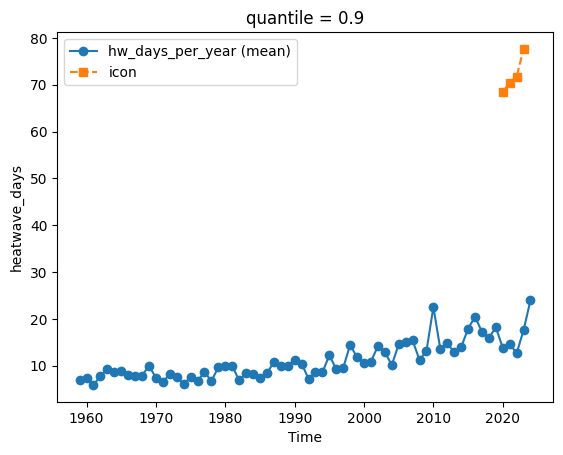

In [29]:
### full
#icon =[ 98.35495703,  87.31060467,  93.17496931, 110.80669122]
### over land
icon = [68.46184086, 70.46775779, 71.7127986 , 77.64506489]
years = ['2020','2021','2022','2023']
years_dt = np.array([np.datetime64(f'{y}-01-01') for y in years])

# Create a single figure and axis
fig, ax = plt.subplots()

# Plot the xarray data on that axis
## sum
#hw_days_per_year.sel(time=slice('2020','2023')).sum(dim=['lat', 'lon']).plot(ax=ax, marker='o', label='hw_days_per_year (sum)')
## mean
hw_days_land.mean(dim=['lat', 'lon']).plot(ax=ax, marker='o', label='hw_days_per_year (mean)')
#hw_days_land.sel(time=slice('2000','2023')).mean(dim=['lat', 'lon']).plot(ax=ax, marker='o', label='hw_days_per_year (mean)')


# Plot your vector data on the same axis
ax.plot(years_dt, icon, marker='s', linestyle='--', label='icon')

ax.set_xlabel('Time')
ax.legend()

In [30]:
# (c) duration per year — Dask-safe, no ndimage, no groupby on chunked labels
'''
# 0/ prep
x = hw_mask  # (time, lat, lon) boolean

# 1) find run starts
start = x & (~x.shift(time=1, fill_value=False))

# 2) numeric time index
idx = xr.DataArray(
    np.arange(x.sizes["time"], dtype=np.int64),
    coords={"time": x.time},
    dims="time",
)

# 3) forward-fill the start index across each run
start_idx = idx.where(start)                     # start index at run starts, NaN elsewhere
start_idx_ffill = start_idx.ffill("time")        # propagate start index forward within runs

# 4) run length per day (only for True days; zeros otherwise)
run_len = xr.where(x, (idx - start_idx_ffill + 1), 0).astype("int32")

# 5a) yearly mean run length
hw_mean_duration_per_year = run_len.resample(time="YS").mean("time").astype("int32")
hw_mean_duration_per_year.name = "mean_heatwave_duration"
# 5b) yearly maximum run length
#hw_max_duration_per_year = run_len.resample(time="YS").max("time").astype("int32")
#hw_max_duration_per_year.name = "max_heatwave_duration"
'''
#new routines
# Boolean mask of heatwave days (already min_duration>=3), shape (time, lat, lon)
x = hw_mask

# run starts (you already had this)
start = x & (~x.shift(time=1, fill_value=False))

# numeric time index
idx = xr.DataArray(np.arange(x.sizes["time"], dtype=np.int64),
                   coords={"time": x.time}, dims="time")

# forward-fill start index and compute per-day run length
start_idx = idx.where(start)
start_idx_ffill = start_idx.ffill("time")
run_len = xr.where(x, (idx - start_idx_ffill + 1), 0).astype("int32")

# --- NEW: pick event lengths only at run ENDS ---
end = x & (~x.shift(time=-1, fill_value=False))          # last day of each event
event_len = run_len.where(end)                            # lengths at ends; NaN elsewhere

# summarize by YEAR OF THE END DAY (change "YS" to "AS-Dec" if you prefer)
hw_mean_duration_per_year = event_len.resample(time="YS").mean("time")
hw_max_duration_per_year  = event_len.resample(time="YS").max("time")

# optional: long-term means/maps
mean_of_yearly_means = hw_mean_duration_per_year.mean("time")
max_of_yearly_max    = hw_max_duration_per_year.max("time")

In [85]:
#hw_max_duration_per_year.mean(dim='time').plot()#levels=np.arange(0,30,3))
#hw_mean_duration_per_year.mean(dim='time').plot()#levels=np.arange(0,30,3))

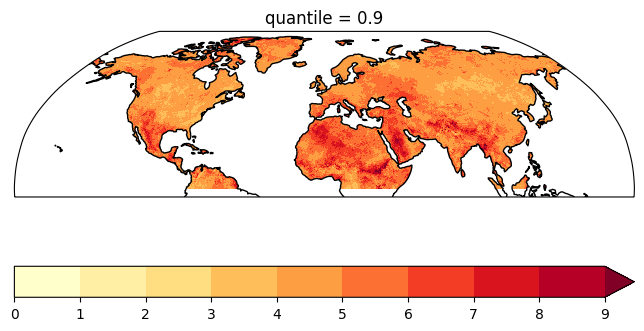

In [86]:
#mean_hw_duration=hw_mean_duration_per_year.sel(time=slice('2000','2024')).mean(dim='time') 
mean_hw_duration=hw_mean_duration_per_year.sel(time=slice('2020','2023')).mean(dim='time') 
# --- Apply mask & plot ---
mean_hw_duration_land = mean_hw_duration.where(mask_da)

proj = ccrs.Robinson(central_longitude=0)
fig, ax1 = plt.subplots(1, 1, figsize=(8, 6), dpi=100, subplot_kw={'projection': proj})

plot = mean_hw_duration_land.plot(
    ax=ax1,
    cmap='YlOrRd',
    levels=np.arange(0, 10, 1),
    transform=ccrs.PlateCarree(),
    extend="max",
    cbar_kwargs={"orientation": "horizontal"}
)
ax1.coastlines()

## distribution of duration

In [35]:
#cc ### distribution

In [36]:
## distribution
def make_land_mask_like(da_2d: xr.DataArray) -> xr.DataArray:
    # discover lat/lon names
    lat_name = next(n for n in da_2d.coords if n.lower().startswith('lat'))
    lon_name = next(n for n in da_2d.coords if n.lower().startswith('lon'))

    # broadcast to 2D lon/lat with consistent dim order
    lon2d, lat2d = xr.broadcast(da_2d[lon_name], da_2d[lat_name])

    # wrap longitudes to [-180, 180] for polygon tests
    lon_wrapped = (((lon2d % 360) + 180) % 360) - 180

    # read Natural Earth land polygons
    shapefile = shpreader.natural_earth(resolution='110m', category='physical', name='land')
    geoms = list(shpreader.Reader(shapefile).geometries())

    # vectorized point-in-polygon
    xv, yv = lon_wrapped.values, lat2d.values
    mask_np = np.zeros(xv.shape, dtype=bool)
    for g in geoms:
        mask_np |= sv.contains(g, xv, yv)

    return xr.DataArray(mask_np, coords={lat_name: lat2d[lat_name], lon_name: lon2d[lon_name]}, dims=lat2d.dims)

def event_lengths_from_hwmask(hw_mask: xr.DataArray, min_duration: int = 3) -> xr.DataArray:
    x = hw_mask  # (time, lat, lon) bool

    start = x & (~x.shift(time=1,  fill_value=False))
    end   = x & (~x.shift(time=-1, fill_value=False))

    idx = xr.DataArray(np.arange(x.sizes["time"], dtype=np.int64), coords={"time": x.time}, dims="time")

    start_idx = idx.where(start)
    start_idx_ffill = start_idx.ffill("time")
    run_len = xr.where(x, (idx - start_idx_ffill + 1), 0)

    event_len = run_len.where(end)
    event_len = event_len.where(event_len >= min_duration)
    return event_len.astype("int16").rename("event_length_days")

# Optional area weights (cos lat), then flatten to samples
def coslat_weights(da: xr.DataArray) -> xr.DataArray:
    lat_name = next(n for n in da.coords if n.lower().startswith('lat'))
    cosw = np.cos(np.deg2rad(da[lat_name]))
    return cosw / cosw.mean()  # normalized, scale-free

def flatten_with_weights(event_len: xr.DataArray, w_lat: xr.DataArray):
    w2d = w_lat.broadcast_like(event_len.isel(time=0))
    w3d, _ = xr.broadcast(w2d, event_len)

    valid = event_len.notnull()
    v = event_len.where(valid).stack(sample=("time","lat","lon")).dropna("sample")
    w = w3d.where(valid).stack(sample=("time","lat","lon")).sel(sample=v["sample"])
    return v.values.astype(np.int16), w.values.astype(np.float32)


#def weighted_hist(values, weights, bins):
#    """
#    Weighted histogram returning raw counts and readable range labels.
#    Example: '3–4', '5–6', '7–8', '9–10', '>10'
#    """
#    counts, edges = np.histogram(values, bins=bins, weights=weights)
#    labels = []
#    for i in range(len(edges) - 1):
#        if i == len(edges) - 2:
#            labels.append(f">{int(edges[i] - 1)}")   # ensures '>10'
#        else:
#            labels.append(f"{int(edges[i])}–{int(edges[i+1] - 1)}")
#    return labels, counts

def weighted_hist(values, weights, bins, mode='count'):
    """
    Weighted histogram returning either raw counts or normalized probabilities (PMF),
    with automatically extended last bin (e.g. '>10').
    
    Parameters
    ----------
    values : array-like
        Input data (e.g. event durations)
    weights : array-like
        Weights for each sample (e.g. cos(lat))
    bins : list or array
        Bin edges (e.g. [3, 5, 7, 9, 11])
        The last edge automatically extends to include all larger values.
    mode : {'count', 'pmf'}
        'count' -> return raw counts
        'pmf'   -> return normalized probabilities (sum to 1)
    
    Returns
    -------
    labels : list of str
        Bin labels like ['3–4', '5–6', '7–8', '9–10', '>10']
    values_out : np.ndarray
        Counts or probabilities per bin
    """
    # Ensure bins cover full range
    bins = np.asarray(bins, dtype=float)
    bins = np.append(bins, np.inf)  # ensures the last bin captures all larger values

    counts, edges = np.histogram(values, bins=bins, weights=weights)

    # Normalize if requested
    if mode == 'pmf':
        total = counts.sum()
        counts = counts / total if total > 0 else counts

    # Build readable labels
    labels = []
    for i in range(len(edges) - 1):
        if np.isinf(edges[i+1]):
            labels.append(f">{int(edges[i] - 1)}")
        else:
            labels.append(f"{int(edges[i])}–{int(edges[i+1] - 1)}")

    return labels, counts
    
def weighted_ecdf(values, weights):
    order = np.argsort(values)
    v = values[order]; w = weights[order]
    cw = np.cumsum(w); cw = cw / cw[-1] if cw[-1] > 0 else cw
    return v, cw

In [44]:
#event_len_model #= event_lengths_from_hwmask(hw_mask_icon)
#Turn hw_mask --> event lengths at run ends
#hw_mask_era5=xr.open_dataset('/capstor/scratch/cscs/edolores/OBS/ERA5/Heatwaves/Russo/hw_mask.nc')['heatwave_day']
#hw_mask_era5=xr.open_dataset('/capstor/scratch/cscs/edolores/OBS/ERA5/Heatwaves/Russo/hw_mask_2020-2024.nc')['heatwave_day']
hw_mask_era5=xr.open_dataset('/capstor/scratch/cscs/edolores/OBS/ERA5/Heatwaves/Russo/hw_mask_2020-2024_jja.nc')['heatwave_day_by_season']
#reusable land mask (once per grid)
land_mask = make_land_mask_like(hw_mask_era5.isel(time=0))  # True over land
event_len_era5 = event_lengths_from_hwmask(hw_mask_era5)  # your ERA5 mask

### 2.5 km icon
#hw_mask_icon=xr.open_dataset('/capstor/scratch/cscs/edolores/EXCLAIM/ICON_2KM/Heatwaves/Russo/hw_mask.nc')['heatwave_day']
#hw_mask_icon=xr.open_dataset('/capstor/scratch/cscs/edolores/EXCLAIM/ICON_2KM/Heatwaves/Russo/hw_mask_simclim.nc')['heatwave_day']
hw_mask_icon=xr.open_dataset('/capstor/scratch/cscs/edolores/EXCLAIM/ICON_2KM/Heatwaves/Russo/hw_mask_simclim_jja.nc')['heatwave_day_by_season']
event_len_model_2km = event_lengths_from_hwmask(hw_mask_icon)

### 10 km icon
#hw_mask_icon=xr.open_dataset('/capstor/scratch/cscs/edolores/EXCLAIM/ICON_10KM/Heatwaves/Russo/hw_mask.nc')['heatwave_day']
#hw_mask_icon=xr.open_dataset('/capstor/scratch/cscs/edolores/EXCLAIM/ICON_10KM/Heatwaves/Russo/hw_mask_simclim.nc')['heatwave_day']
hw_mask_icon=xr.open_dataset('/capstor/scratch/cscs/edolores/EXCLAIM/ICON_10KM/Heatwaves/Russo/hw_mask_simclim_jja.nc')['heatwave_day_by_season']
event_len_model_10km = event_lengths_from_hwmask(hw_mask_icon)

### 10 km icon ON
#hw_mask_icon=xr.open_dataset('/capstor/scratch/cscs/edolores/EXCLAIM/ICON_10KM-ON/Heatwaves/Russo/hw_mask.nc')['heatwave_day']
#hw_mask_icon=xr.open_dataset('/capstor/scratch/cscs/edolores/EXCLAIM/ICON_10KM-ON/Heatwaves/Russo/hw_mask_simclim.nc')['heatwave_day']
hw_mask_icon=xr.open_dataset('/capstor/scratch/cscs/edolores/EXCLAIM/ICON_10KM-ON/Heatwaves/Russo/hw_mask_simclim_jja.nc')['heatwave_day_by_season']
event_len_model_10km_on = event_lengths_from_hwmask(hw_mask_icon)

### old icon
###hw_mask_icon=xr.open_dataset('/capstor/scratch/cscs/edolores/old_icon/Heatwaves/Russo/hw_mask_simclim.nc')['heatwave_day']
###hw_mask_icon_old=xr.open_dataset('/capstor/scratch/cscs/edolores/old_icon/Heatwaves/Russo/hw_mask_simclim_jja.nc')['heatwave_day_by_season']
###event_len_model_old = event_lengths_from_hwmask(hw_mask_icon_old)
### Destination Earth
###hw_mask_icon_dt=xr.open_dataset('/capstor/scratch/cscs/edolores/icon-climate-dt/Heatwaves/Russo/hw_mask_simclim_jja.nc')['heatwave_day_by_season']
###event_len_model_dt = event_lengths_from_hwmask(hw_mask_icon_dt)

/tmp/ipykernel_6111/1423616566.py:21: DeprecationWarning: The 'shapely.vectorized.contains' function is deprecated and will be removed a future version. Use 'shapely.contains_xy' instead (available since shapely 2.0.0).
  mask_np |= sv.contains(g, xv, yv)
/users/edolores/.env_icon/lib/python3.12/site-packages/xarray/core/duck_array_ops.py:250: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
/users/edolores/.env_icon/lib/python3.12/site-packages/xarray/core/duck_array_ops.py:250: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
/users/edolores/.env_icon/lib/python3.12/site-packages/xarray/core/duck_array_ops.py:250: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
/users/edolores/.env_icon/lib/python3.12/site-packages/xarray/core/duck_array_ops.py:250: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)


In [45]:
# --- Ensure sorted time ---
event_len_era5  = event_len_era5.sortby("time")
event_len_model_2km = event_len_model_2km.sortby("time")
event_len_model_10km = event_len_model_10km.sortby("time")
event_len_model_10km_on = event_len_model_10km_on.sortby("time")
#event_len_model_old = event_len_model_old.sortby("time")
#event_len_model_dt = event_len_model_dt.sortby("time")

event_len_era5['time']  = event_len_era5.time.dt.floor('D')
event_len_model_2km['time'] = event_len_model_2km.time.dt.floor('D')
event_len_model_10km['time'] = event_len_model_10km.time.dt.floor('D')
event_len_model_10km_on['time'] = event_len_model_10km_on.time.dt.floor('D')
#event_len_model_old['time'] = event_len_model_old.time.dt.floor('D')
#event_len_model_dt['time'] = event_len_model_dt.time.dt.floor('D')


### --- Find common overlapping period (if any) ---
#tmin = max(event_len_era5.time.min(), event_len_model.time.min())
#tmax = min(event_len_era5.time.max(), event_len_model.time.max())
#
## Only slice if overlap exists
#if tmin < tmax:
#    event_len_era5  = event_len_era5.sel(time=slice(tmin, tmax))
#    event_len_model = event_len_model.sel(time=slice(tmin, tmax))
#else:
#    print("⚠️ No overlapping time range — proceeding without temporal alignment.")
#
# --- Align datasets on shared dims ---
#event_len_era5, event_len_model = xr.align(event_len_era5, event_len_model, join="inner")
# --- Apply land mask (broadcast safely) ---
#land_mask3d = land_mask.broadcast_like(event_len_era5)
#event_len_era5_land  = event_len_era5.where(land_mask3d)
#event_len_model_land = event_len_model.where(land_mask3d)

# Separate land masks for each dataset
land_mask_era5  = make_land_mask_like(event_len_era5.isel(time=0))
land_mask_model_2km = make_land_mask_like(event_len_model_2km.isel(time=0))
land_mask_model_10km = make_land_mask_like(event_len_model_10km.isel(time=0))
land_mask_model_10km_on = make_land_mask_like(event_len_model_10km_on.isel(time=0))
#land_mask_model_old = make_land_mask_like(event_len_model_old.isel(time=0))
#land_mask_model_dt = make_land_mask_like(event_len_model_dt.isel(time=0))

# Broadcast and apply individually
lm_era5_3d, _  = xr.broadcast(land_mask_era5,  event_len_era5)
lm_model_3d_2km, _ = xr.broadcast(land_mask_model_2km, event_len_model_2km)
lm_model_3d_10km, _ = xr.broadcast(land_mask_model_10km, event_len_model_10km)
lm_model_3d_10km_on, _ = xr.broadcast(land_mask_model_10km_on, event_len_model_10km_on)
#lm_model_3d_old, _ = xr.broadcast(land_mask_model_old, event_len_model_old)
#lm_model_3d_dt, _ = xr.broadcast(land_mask_model_dt, event_len_model_dt)

event_len_era5_land  = event_len_era5.where(lm_era5_3d)
event_len_model_land_2km = event_len_model_2km.where(lm_model_3d_2km)
event_len_model_land_10km = event_len_model_10km.where(lm_model_3d_10km)
event_len_model_land_10km_on = event_len_model_10km_on.where(lm_model_3d_10km_on)
#event_len_model_land_old = event_len_model_old.where(lm_model_3d_old)
#event_len_model_land_dt = event_len_model_dt.where(lm_model_3d_dt)

print("ERA5 time:", event_len_era5.time[0].values, "→", event_len_era5.time[-1].values)
print("ICON_2km time:", event_len_model_2km.time[0].values, "→", event_len_model_2km.time[-1].values)
print("ICON time_10km :", event_len_model_10km.time[0].values, "→", event_len_model_10km.time[-1].values)
print("ICON time_10km_on:", event_len_model_10km_on.time[0].values, "→", event_len_model_10km_on.time[-1].values)
#print("ICON old time:", event_len_model_old.time[0].values, "→", event_len_model_old.time[-1].values)
#print("ICON dt time:", event_len_model_dt.time[0].values, "→", event_len_model_dt.time[-1].values)
#print("Common dims:", event_len_era5.dims, event_len_model.dims)

# Weights per dataset
wlat_era5  = coslat_weights(event_len_era5_land)
wlat_model_2km = coslat_weights(event_len_model_land_2km)
wlat_model_10km = coslat_weights(event_len_model_land_10km)
wlat_model_10km_on = coslat_weights(event_len_model_land_10km_on)
#wlat_model_old = coslat_weights(event_len_model_land_old)
#wlat_model_dt = coslat_weights(event_len_model_land_dt)

# Flatten separately
v_era5,  w_era5  = flatten_with_weights(event_len_era5_land,  wlat_era5)
v_model_2km, w_model_2km = flatten_with_weights(event_len_model_land_2km, wlat_model_2km)
v_model_10km, w_model_10km = flatten_with_weights(event_len_model_land_10km, wlat_model_10km)
v_model_10km_on, w_model_10km_on = flatten_with_weights(event_len_model_land_10km_on, wlat_model_10km_on)
#v_model_old, w_model_old = flatten_with_weights(event_len_model_land_old, wlat_model_old)
#v_model_dt, w_model_dt = flatten_with_weights(event_len_model_land_dt, wlat_model_dt)

/tmp/ipykernel_6111/1423616566.py:21: DeprecationWarning: The 'shapely.vectorized.contains' function is deprecated and will be removed a future version. Use 'shapely.contains_xy' instead (available since shapely 2.0.0).
  mask_np |= sv.contains(g, xv, yv)


ERA5 time: 2020-01-20T00:00:00.000000000 → 2024-04-01T00:00:00.000000000
ICON_2km time: 2020-01-20T00:00:00.000000000 → 2024-04-01T00:00:00.000000000
ICON time_10km : 2020-01-20T00:00:00.000000000 → 2024-04-01T00:00:00.000000000
ICON time_10km_on: 2020-01-20T00:00:00.000000000 → 2024-04-01T00:00:00.000000000


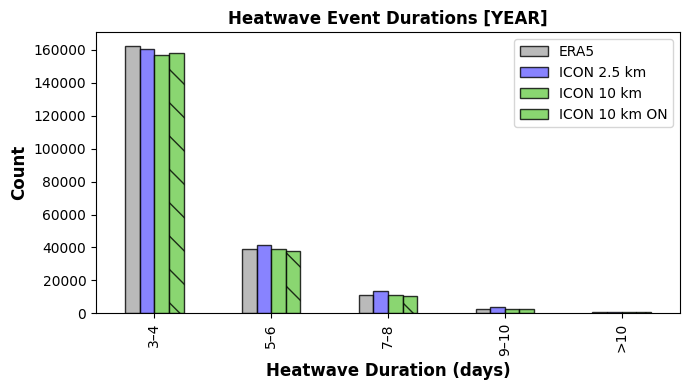

In [46]:
###  new plotting probability
sufix='YEAR'
domain='NH'
# Example bins
bins = [3, 5, 7, 9, 11]  # → bins: 3–4, 5–6, 7–8, 9–10, >10
labels, c_e     = weighted_hist(v_era5,       w_era5,       bins)
labels, c_m_2km     = weighted_hist(v_model_2km,      w_model_2km,      bins)
labels, c_m_10km     = weighted_hist(v_model_10km,      w_model_10km,      bins)
labels, c_m_10km_on     = weighted_hist(v_model_10km_on,      w_model_10km_on,      bins)
#labels, c_m_old = weighted_hist(v_model_old,  w_model_old,  bins)
#labels, c_m_dt  = weighted_hist(v_model_dt,   w_model_dt,   bins)

# Normalized probabilities
labels, c_e = weighted_hist(v_era5, w_era5, bins, mode='count')
labels, c_m_2km     = weighted_hist(v_model_2km,      w_model_2km,      bins, mode='count')
labels, c_m_10km     = weighted_hist(v_model_10km,      w_model_10km,      bins, mode='count')
labels, c_m_m_10km_on  = weighted_hist(v_model_10km_on,      w_model_10km_on,      bins, mode='count')
#labels,  c_m_old = weighted_hist(v_model_old,  w_model_old,  bins, mode='count')
#labels, c_m_dt   = weighted_hist(v_model_dt,   w_model_dt,   bins, mode='count')

duration_df = pd.DataFrame({
    'ERA5': c_e,
    'ICON 2.5 km': c_m_2km,
    'ICON 10 km': c_m_10km,
    'ICON 10 km ON': c_m_10km_on,
#    'ICON 40 km': c_m_old
}, index=labels)

hatch_patterns = {
    'ERA5': '',
    'ICON 2.5 km': '',
    'ICON 10 km': '',
    'ICON 10 km ON': '\\',
#    'ICON 40 km': '\\'
}

ax = duration_df.plot(
    kind='bar',
    figsize=(7, 4),
#    color=['darkgrey', '#6b64ff', '#6b64ff', '#6b64ff'],
    color=['darkgrey', '#6b64ff', '#6dcc4e', '#6dcc4e'],
    alpha=0.8,
    edgecolor='black'
)

# Apply hatching consistently
for bar_container, dataset_name in zip(ax.containers, duration_df.columns):
    for bar in bar_container:
        bar.set_hatch(hatch_patterns[dataset_name])
        
ax.set_xlabel('Heatwave Duration (days)', fontsize=12, weight='bold')
ax.set_ylabel('Count', fontsize=12, weight='bold')
ax.set_title('Heatwave Event Durations [' + sufix + ']', fontsize=12, weight='bold')
plt.tight_layout()

#plt.savefig(dir_figures+'Duration_PerGrid_byGroup_'+sufix+'_'+domain+'.jpg',dpi=300, facecolor='white', bbox_inches='tight', pad_inches=0)

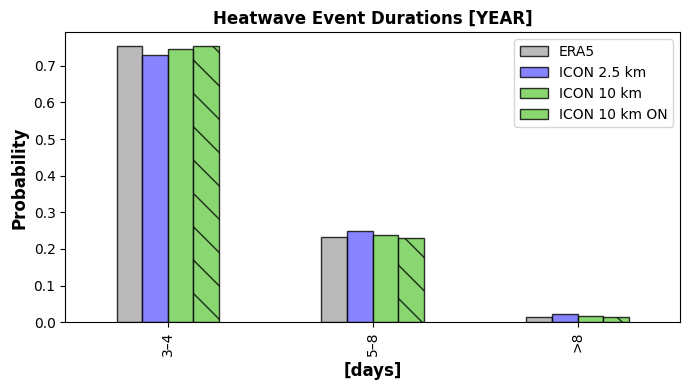

In [47]:
### new version of plotting
sufix='YEAR'
domain='NH'
#bins = [3, 5, 7, 9, 11]  # → bins: 3–4, 5–6, 7–8, 9–10, >10
bins = [3, 5, 9]  # → bins: 3–4, 5–6, 7–8, 9–10, >10

# Raw counts
#labels, counts_era5 = weighted_hist(v_era5, w_era5, bins, mode='count')

# Normalized probabilities
labels, pmf_era5 = weighted_hist(v_era5, w_era5, bins, mode='pmf')
c_m_2km, pmf_m_2km     = weighted_hist(v_model_2km,      w_model_2km,      bins, mode='pmf')
c_m_10km, pmf_m_10km = weighted_hist(v_model_10km,  w_model_10km,  bins, mode='pmf')
c_m_10km_on, pmf_m_10km_on   = weighted_hist(v_model_10km_on,   w_model_10km_on,   bins, mode='pmf')

duration_df = pd.DataFrame({
    'ERA5': pmf_era5,
    'ICON 2.5 km': pmf_m_2km,
    'ICON 10 km': pmf_m_10km,
    'ICON 10 km ON': pmf_m_10km_on
}, index=labels)

hatch_patterns = {
    'ERA5': '',
    'ICON 2.5 km': '',
    'ICON 10 km': '',
    'ICON 10 km ON': '\\'
}

ax = duration_df.plot(kind='bar', figsize=(7,4), color=['darkgrey', '#6b64ff', '#6dcc4e','#6dcc4e'],    alpha=0.8, edgecolor='black')
#ax = duration_df.plot(kind='bar', figsize=(7,4), color=['darkgrey', '#6b64ff', '#6dcc4e',],    alpha=0.8, edgecolor='black')



# Apply hatching consistently
for bar_container, dataset_name in zip(ax.containers, duration_df.columns):
    for bar in bar_container:
        bar.set_hatch(hatch_patterns[dataset_name])
        
ax.set_xlabel('[days]', fontsize=12, weight='bold')
ax.set_ylabel('Probability' if True else 'Count', fontsize=12, weight='bold')
ax.set_title('Heatwave Event Durations [' + sufix + ']', fontsize=12, weight='bold')
plt.tight_layout()

plt.savefig(dir_figures+'Duration_PerGrid_byGroup_'+sufix+'_'+domain+'.jpg',dpi=300, facecolor='white', bbox_inches='tight', pad_inches=0)

## 3) Season-split — returns a [season, time, lat, lon] boolean mask

In [14]:
### main line 
### this works quickly for shorth periods , e.g., 5 years
season_hw = split_heatwaves_by_season(hw_mask)
season_hw 

NameError: name 'hw_mask' is not defined

In [16]:
### average per season
## if we have not computed in SBATCH, we uncommment the next line
#summer = season_hw.sel(season="JJA")                 # includes May–Sep by design
summer = season_hw.sel(season="DJF")                 # includes Nov–Mar by design

summer_yearly = summer.groupby("time.year").sum("time") # days per year at each gridpoint
summer_yearly_mean = summer_yearly.mean("year").compute()         # average per year
summer_yearly_mean.attrs["units"] = "days per season"
#summer_yearly_mean.attrs["long_name"] = "Mean JJA heatwave days per season"
summer_yearly_mean.attrs["long_name"] = "Mean DJF heatwave days per season"
print(summer_yearly_mean.max().values)


9.6


In [17]:
# Example: counts full period and selecting summer (this takes too much time)
#season_counts = season_hw.sum("time")  # days per season at each gridpoint
#da_s = season_counts.sel(season='JJA').compute()  # or .load() / .persist()

#Computed below for a shorth period in this notebook below
#summer =xr.open_dataset('/capstor/scratch/cscs/edolores/OBS/ERA5/Heatwaves/Russo/hw_mask_2020-2024_jja.nc')['heatwave_day_by_season']
#summer

## Computed by sbatch and get_hw_season.py:
#summer_yearly_mean =xr.open_dataset('/capstor/scratch/cscs/edolores/OBS/ERA5/Heatwaves/Russo/jja_yearly_mean.nc')['heatwave_day_by_season']

In [8]:
###

In [43]:
#jja_yearly_mean.plot()
mask_da = make_land_mask(summer_yearly_mean)  # domain = "NH" or "SH"

/tmp/ipykernel_240230/3703669743.py:46: DeprecationWarning: The 'shapely.vectorized.contains' function is deprecated and will be removed a future version. Use 'shapely.contains_xy' instead (available since shapely 2.0.0).
  mask_np |= sv.contains(g, xv, yv)


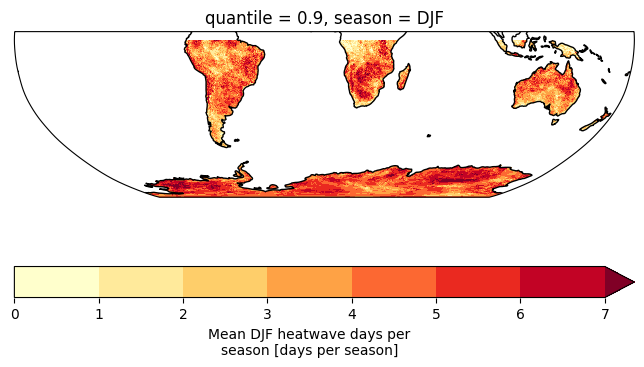

In [20]:
# --- Apply mask & plot ---
da_s_land = summer_yearly_mean.where(mask_da)

proj = ccrs.Robinson(central_longitude=0, globe=None)

fig, ax1 = plt.subplots(1, 1, figsize=(8, 6), dpi=100, subplot_kw={'projection': proj})

p = da_s_land.plot.pcolormesh(ax=ax1,
                       cmap='YlOrRd',
#                       vmin=0, vmax=50,         # instead of levels=...
                       levels=np.arange(0, 8, 1),
                       transform=ccrs.PlateCarree(),
                       add_colorbar=True,
                       cbar_kwargs={'orientation': 'horizontal'},
                       rasterized=True)          # speeds up vector backends
# Add features
#ax1.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', 
#                                            edgecolor='face', facecolor='grey', alpha=0.30), zorder=20)
ax1.coastlines('110m')                            # lighter than land polygons

In [31]:
### saving seasonal hw mask
#NH
#summer.to_netcdf('/capstor/scratch/cscs/edolores/OBS/ERA5/Heatwaves/Russo/hw_mask_2020-2024_jja.nc')
#SH
#summer.to_netcdf('/capstor/scratch/cscs/edolores/OBS/ERA5/Heatwaves/Russo/SH/hw_mask_2020-2024_djf.nc')

In [32]:
### Final plot

In [33]:
domain='NH' # SH, NH
sufix='JJA'
if domain == 'NH':
    if sufix=='JJA':
        jja_era5=xr.open_dataset('/capstor/scratch/cscs/edolores/OBS/ERA5/Heatwaves/Russo/hw_mask_2020-2024_jja.nc')['heatwave_day_by_season']
        jja_icon=xr.open_dataset('/capstor/scratch/cscs/edolores/EXCLAIM/ICON_2KM/Heatwaves/Russo/hw_mask_simclim_jja.nc')['heatwave_day_by_season']
        jja_icon10km=xr.open_dataset('/capstor/scratch/cscs/edolores/EXCLAIM/ICON_10KM/Heatwaves/Russo/hw_mask_simclim_jja.nc')['heatwave_day_by_season']
        jja_icon10km_on=xr.open_dataset('/capstor/scratch/cscs/edolores/EXCLAIM/ICON_10KM-ON/Heatwaves/Russo/hw_mask_simclim_jja.nc')['heatwave_day_by_season']
    if sufix=='YEAR':
        jja_era5=xr.open_dataset('/capstor/scratch/cscs/edolores/OBS/ERA5/Heatwaves/Russo/hw_mask_2020-2024.nc')['heatwave_day']
        jja_icon=xr.open_dataset('/capstor/scratch/cscs/edolores/EXCLAIM/ICON_2KM/Heatwaves/Russo/hw_mask_simclim.nc')['heatwave_day']
        jja_icon10km=xr.open_dataset('/capstor/scratch/cscs/edolores/EXCLAIM/ICON_10KM/Heatwaves/Russo/hw_mask_simclim.nc')['heatwave_day']
        jja_icon10km_on=xr.open_dataset('/capstor/scratch/cscs/edolores/EXCLAIM/ICON_10KM-ON/Heatwaves/Russo/hw_mask_simclim.nc')['heatwave_day']
if domain == 'SH':
    sufix='DJF'
    jja_era5=xr.open_dataset('/capstor/scratch/cscs/edolores/OBS/ERA5/Heatwaves/Russo/SH/hw_mask_2020-2024_djf.nc')['heatwave_day_by_season']
    jja_icon=xr.open_dataset('/capstor/scratch/cscs/edolores/EXCLAIM/ICON_2KM/Heatwaves/Russo/SH/hw_mask_simclim_djf.nc')['heatwave_day_by_season']
#    sufix='YEAR'
#    jja_era5=xr.open_dataset('/capstor/scratch/cscs/edolores/OBS/ERA5/Heatwaves/Russo/SH/hw_mask_2020-2024.nc')['heatwave_day']
#    jja_icon=xr.open_dataset('/capstor/scratch/cscs/edolores/EXCLAIM/ICON_2KM/Heatwaves/Russo/SH/hw_mask_simclim.nc')['heatwave_day']


# includes May–Sep by design era5
jja_yearly = jja_era5.groupby("time.year").sum("time") # days per year at each gridpoint
mean_hw_days = jja_yearly.mean("year").compute()         # average per year
mean_hw_days.attrs["units"] = "days per season"
mean_hw_days.attrs["long_name"] = "Mean JJA heatwave days per season"

# includes May–Sep by design icon 2.5 km
jja_yearly = jja_icon.groupby("time.year").sum("time") # days per year at each gridpoint
mean_hw_days_icon = jja_yearly.mean("year").compute()         # average per year
mean_hw_days_icon.attrs["units"] = "days per season"
mean_hw_days_icon.attrs["long_name"] = "Mean JJA heatwave days per season"

# includes May–Sep by design icon 10 km
'''
# Rename if needed (only if your dims are not exactly 'lat'/'lon')
icon10_ll = jja_icon10km.assign_coords(
    lon=(((jja_icon10km.lon + 180) % 360) - 180)
).sortby('lon')

# 1) convert to numeric
icon10_num = icon10_ll.astype("float32")

# 2) interpolate (linear gives a fractional "coverage/probability" field)
icon10_frac_on_icon2 = icon10_num.interp(
    lat=jja_icon.lat,
    lon=jja_icon.lon,
    method="linear"
)
# 3) choose a threshold and convert back to boolean
icon10_on_icon2 = icon10_frac_on_icon2 >= 0.5   # or > 0.0, or >= 0.9, et
jja_yearly10km = icon10_on_icon2.groupby("time.year").sum("time") # days per year at each gridpoint
'''
jja_yearly = jja_icon10km.groupby("time.year").sum("time") # days per year at each gridpoint
mean_hw_days_icon10km = jja_yearly.mean("year").compute()         # average per year
mean_hw_days_icon10km.attrs["units"] = "days per season"
mean_hw_days_icon10km.attrs["long_name"] = "Mean JJA heatwave days per season"

# includes May–Sep by design icon 10 km ON
jja_yearly = jja_icon10km_on.groupby("time.year").sum("time") # days per year at each gridpoint
mean_hw_days_icon10km_on = jja_yearly.mean("year").compute()         # average per year
mean_hw_days_icon10km_on.attrs["units"] = "days per season"
mean_hw_days_icon10km_on.attrs["long_name"] = "Mean JJA heatwave days per season"

##bias 
mean_hw_days_bias = mean_hw_days_icon-mean_hw_days
mean_hw_days_bias10km = mean_hw_days_icon10km-mean_hw_days
mean_hw_days_bias10km_on = mean_hw_days_icon10km_on-mean_hw_days

##res bias
mean_hw_days_res = mean_hw_days_icon-mean_hw_days_icon10km
##conv bias
mean_hw_days_deep = mean_hw_days_icon10km-mean_hw_days_icon10km_on

##mask ocean
mask_da = make_land_mask(mean_hw_days, hemisphere=domain)  # domain = "NH" or "SH"
mean_hw_days_land = mean_hw_days.where(mask_da)
mean_hw_days_land_icon = mean_hw_days_icon.where(mask_da)
mean_hw_days_land_bias = mean_hw_days_bias.where(mask_da)
mean_hw_days_land_bias10km = mean_hw_days_bias10km.where(mask_da)
mean_hw_days_land_bias10km_on = mean_hw_days_bias10km_on.where(mask_da)
mean_hw_days_land_res = mean_hw_days_res.where(mask_da)
mean_hw_days_land_deep = mean_hw_days_deep.where(mask_da)

data_list = [mean_hw_days_land, mean_hw_days_land_bias, mean_hw_days_land_bias10km, mean_hw_days_land_bias10km_on, mean_hw_days_land_res, mean_hw_days_land_deep]
#data_list = [mean_hw_days_land, mean_hw_days_land_bias, mean_hw_days_land_bias10km, mean_hw_days_land_bias10km_on]


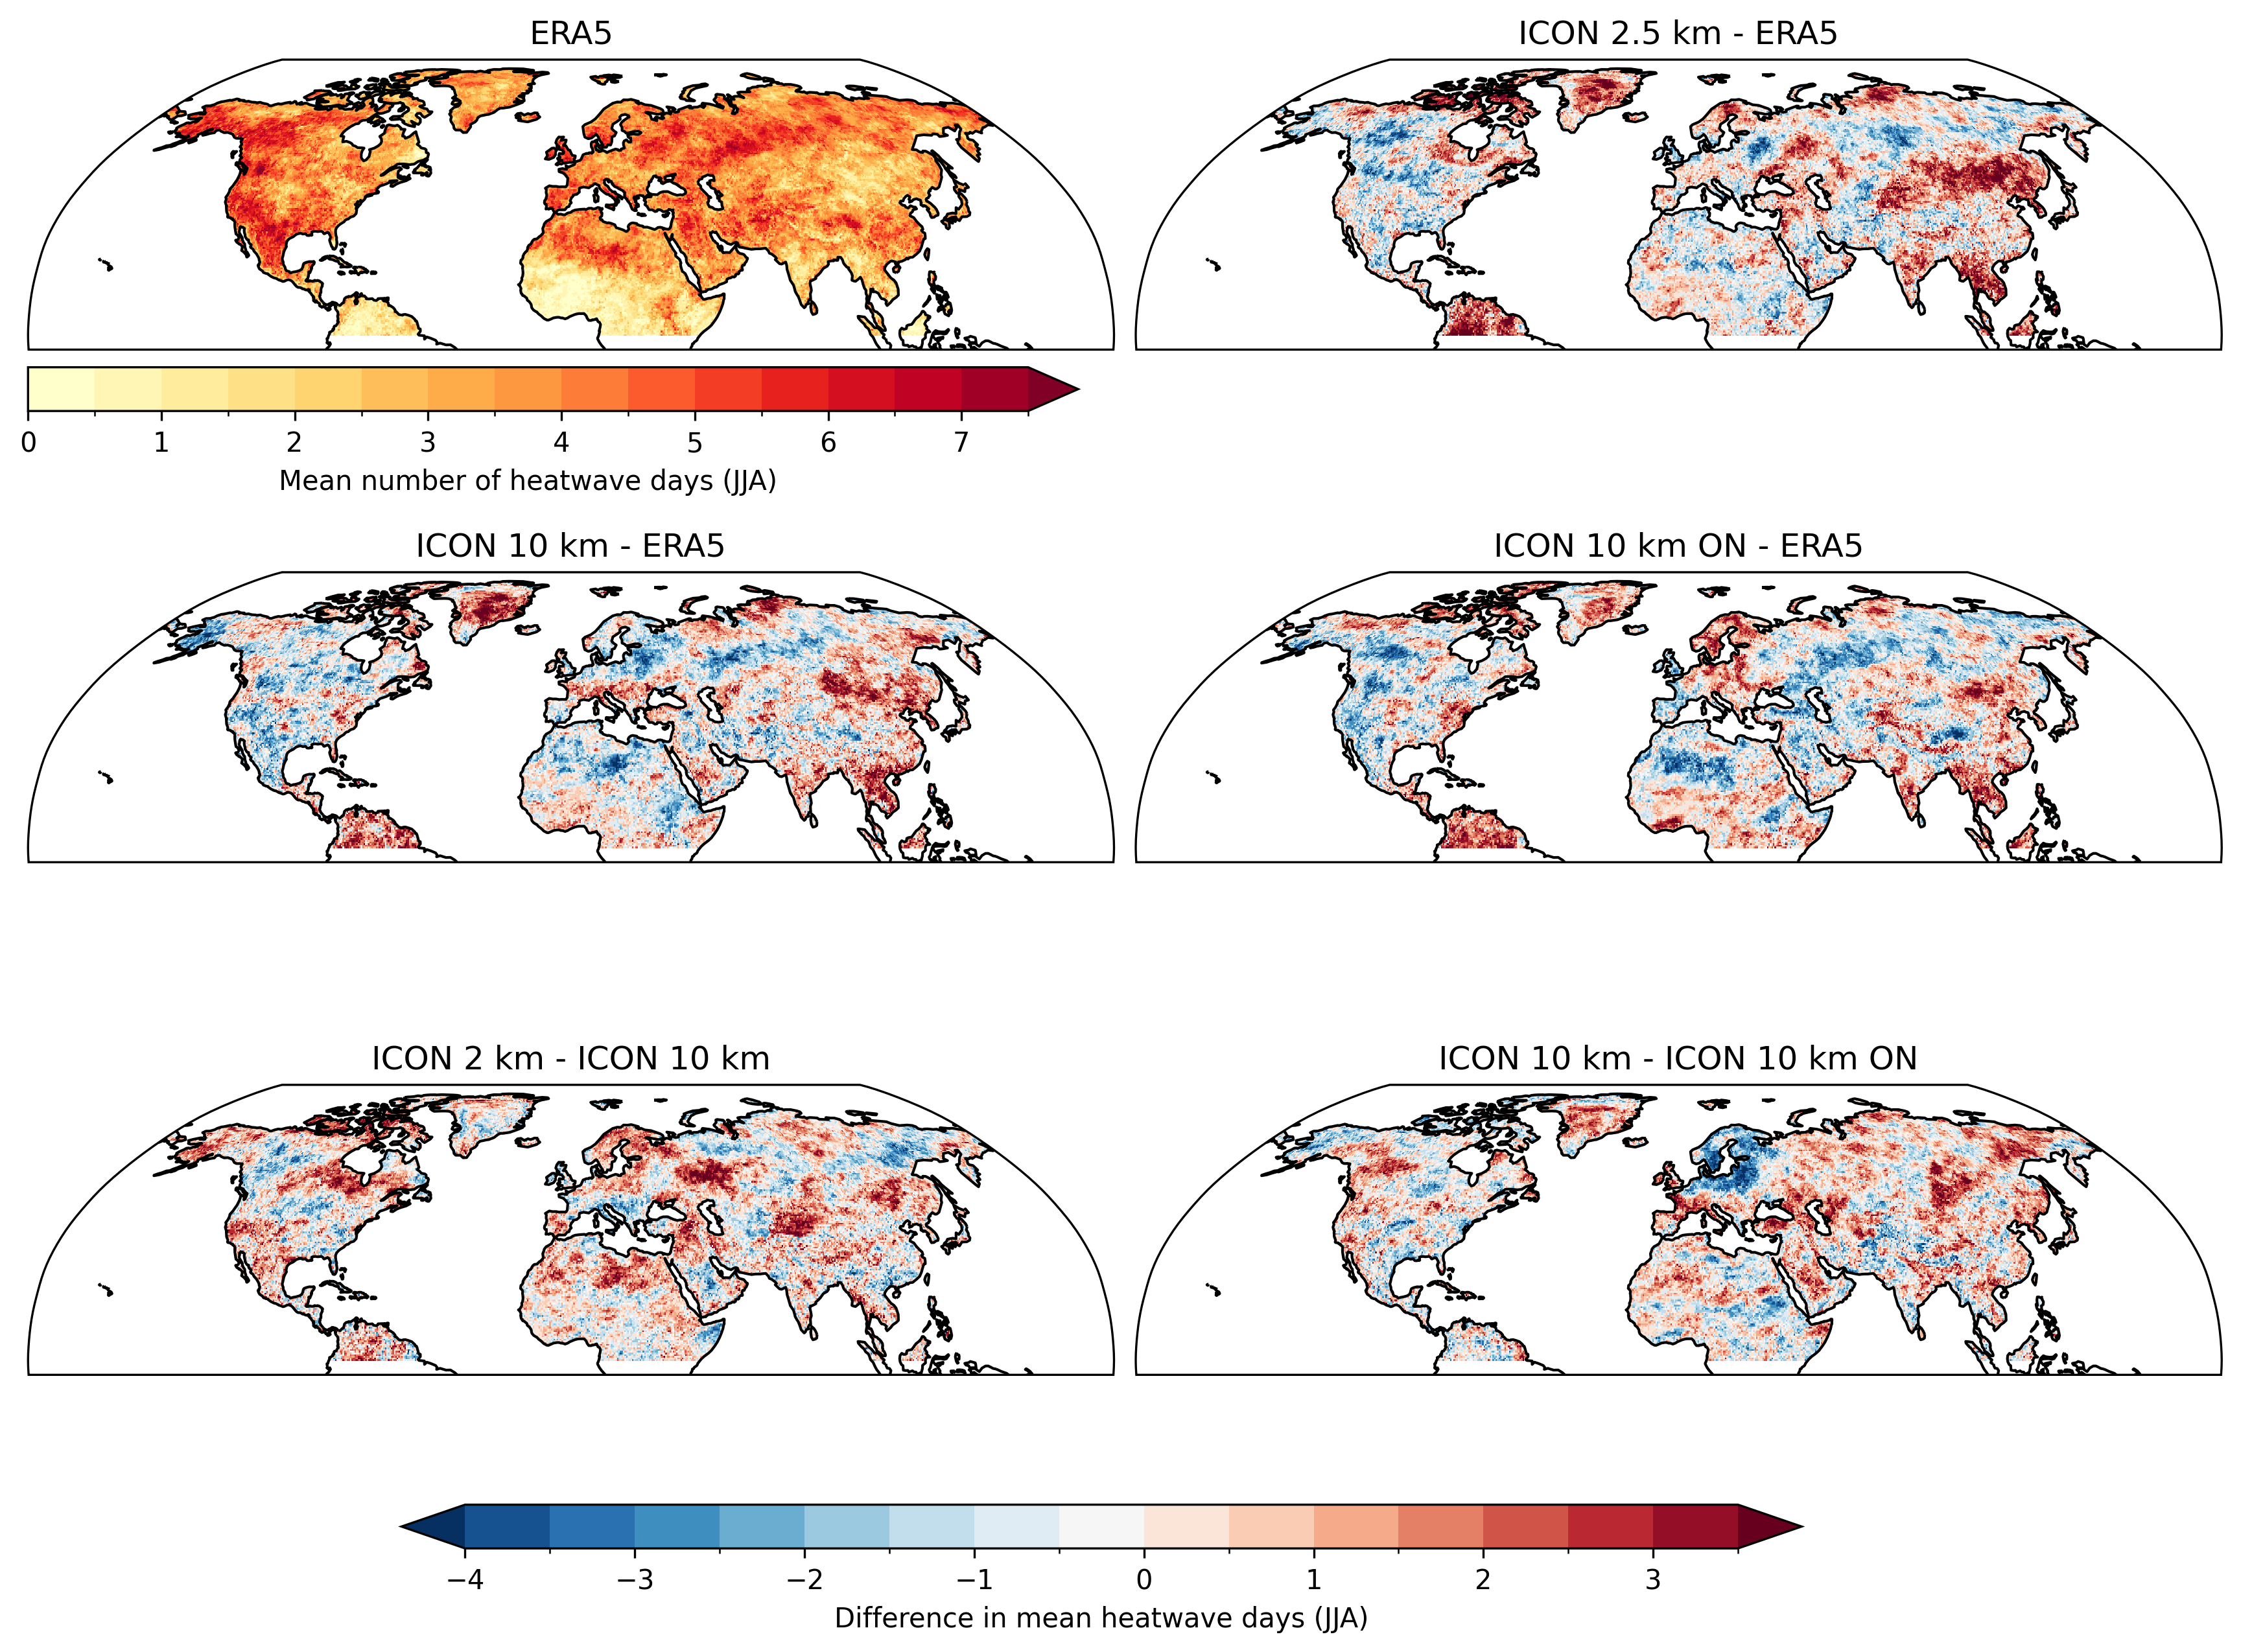

In [34]:
### Plot ERA5 and ICON 2.5 km
proj = ccrs.Robinson(central_longitude=0)

fig, axes = plt.subplots(
    3, 2, figsize=(12, 9), dpi=300, #  figsize=(14, 6)
    subplot_kw={'projection': proj}
)
#fig, axes = plt.subplots(
#    2, 2, figsize=(14, 6), dpi=300, #  figsize=(14, 6)
#    subplot_kw={'projection': proj}
#)

### JJA
levels  = np.arange(0, 8, 0.5)      # absolute
alevels = np.arange(-4, 4, 0.5)     # anomalies
##YEAR
#levels  = np.arange(0, 20, 1)      # absolute
#alevels = np.arange(-8, 8, 1)     # anomalies

# --- Plot panels (NO colorbars here) ---
p_abs = mean_hw_days_land.plot(
    ax=axes[0,0], cmap='YlOrRd', levels=levels,
    transform=ccrs.PlateCarree(), extend='max',
    add_colorbar=False
)
axes[0,0].coastlines()
axes[0,0].set_title('ERA5')

p_an1 = mean_hw_days_land_bias.plot(
    ax=axes[0,1], cmap='RdBu_r', levels=alevels,
    transform=ccrs.PlateCarree(), extend='both',
    add_colorbar=False
)
axes[0,1].coastlines()
axes[0,1].set_title('ICON 2.5 km - ERA5')

p_an2 = mean_hw_days_land_bias10km.plot(
    ax=axes[1,0], cmap='RdBu_r', levels=alevels,
    transform=ccrs.PlateCarree(), extend='both',
    add_colorbar=False
)
axes[1,0].coastlines()
axes[1,0].set_title('ICON 10 km - ERA5')


# Example: your 4th panel anomaly
p_an3 = mean_hw_days_land_bias10km_on.plot(
    ax=axes[1,1], cmap='RdBu_r', levels=alevels,
    transform=ccrs.PlateCarree(), extend='both',
    add_colorbar=False
)
axes[1,1].coastlines()
axes[1,1].set_title('ICON 10 km ON - ERA5')

p_an5 = mean_hw_days_land_res.plot(
    ax=axes[2,0], cmap='RdBu_r', levels=alevels,
    transform=ccrs.PlateCarree(), extend='both',
    add_colorbar=False
)
axes[2,0].coastlines()
axes[2,0].set_title('ICON 2 km - ICON 10 km')

p_an6 = mean_hw_days_land_deep.plot(
    ax=axes[2,1], cmap='RdBu_r', levels=alevels,
    transform=ccrs.PlateCarree(), extend='both',
    add_colorbar=False
)
axes[2,1].coastlines()
axes[2,1].set_title('ICON 10 km - ICON 10 km ON')

# ---- Layout: create space for colorbars ----
# Leave room at bottom for anomaly cbar and between rows for absolute cbar
fig.subplots_adjust(left=0.04, right=0.98, top=0.95, bottom=0.12,
                    wspace=0.02, hspace=0.20)

# ---- Two horizontal colorbars with explicit positions ----
# [left, bottom, width, height] in figure coordinates (0..1)

# Absolute colorbar: centered between rows (tune "bottom" as needed)
cax_abs = fig.add_axes([0.04, 0.71, 0.45, 0.025])
#cax_abs = fig.add_axes([0.04, 0.58, 0.45, 0.025]) 
cbar_abs = fig.colorbar(p_abs, cax=cax_abs, orientation='horizontal')
cbar_abs.set_label('Mean number of heatwave days (JJA)')

# Anomaly colorbar: bottom of figure spanning most of the width
cax_anom = fig.add_axes([0.20, 0.06, 0.60, 0.025])
cbar_anom = fig.colorbar(p_an1, cax=cax_anom, orientation='horizontal')
cbar_anom.set_label('Difference in mean heatwave days (JJA)')

# Hide unused axes
for ax in axes.flatten()[len(data_list):]:
    ax.set_visible(False)

#plt.tight_layout()

plt.savefig(
    dir_figures + f'Heatwave_days_{sufix}_{domain}.jpg',
    dpi=300, facecolor='white', bbox_inches='tight', pad_inches=0
)

# Tracking heatwaves

In [7]:
### Preparing data to track heatwaves

In [8]:
def calculate_smoothed_field(
    data,
    passes,
    weights=np.array([[0, 1, 0], [1, 2, 1], [0, 1, 0]]),
    mode="wrap",
    *args,
    **kwargs
):
    """
    Calculate smoothed field based on a two-dimensional weight kernel
    and multiple smoothing passes. Default weight kernel is a 3x3
    5-point smoothing with double-weighted centre. The arguments
    "weight" and "mode" must be accepted by scipy.ndimage.convolve.
    Values at the latitude border are always set to NaN.
    Dimension names ("time_name", "lon_name", "lat_name"), size ("ntime", "nlon", "nlat")
    and resolution ("dlon", "dlat") can be passed as key=value arguments.

    Parameters
    ----------
        data : xarray.DataArray
            data to smooth
        passes : int or float
            number of smoothing passes of the 5-point smoothing
        weigths : array_like, optional
            array of weight, two-dimensional
            (see scipy.ndimage.convolve function)
        mode : string, optional
            defines how the array is extended at boundaries
            (see scipy.ndimage.convolve function)

    Returns
    -------
        smoothed data: xarray.DataArray
            Data containing the smoothed field
    """

    # perform smoothing
    smoothed = []
    for step in data[kwargs["time_name"]]:
        temp = data.sel({kwargs["time_name"]: step})
        for p in range(passes):
            temp = ndimage.convolve(temp, weights=weights, mode=mode) / np.sum(weights)

        # set latitude border values to nan
        border_size = int(weights.shape[0] / 2 + 0.5)
        temp[np.arange(-border_size, border_size), :] = np.nan

        smoothed.append(temp)

    # define DataArray
    da = xr.DataArray(
        smoothed,
        coords=[
            data[kwargs["time_name"]],
            data[kwargs["lat_name"]],
            data[kwargs["lon_name"]],
        ],
    )

    # set name
    da.name = "smooth_" + data.name

    # assign attributes
    da = da.assign_attrs(data.attrs)
    da.attrs["smooth_passes"] = passes

    return da

In [22]:
#Get full dataset
inpath= '/capstor/scratch/cscs/edolores/OBS/ERA5/T850_era5/' #'/capstor/scratch/cscs/edolores/OBS/ERA5/TS_era5/' # #
fvar='t850' #'t2m' # 't850' 
dvar='t' #'t2m' #'t' 
temp = xr.open_mfdataset(
    inpath+'/'+fvar+'_day_*_0p5deg.nc', 
    chunks={"time": 365, "lon": -1, "lat": -1},preprocess=preprocess,combine="by_coords")[dvar].squeeze()
temp

<xarray.DataArray 't' (time: 24106, lat: 181, lon: 720)> Size: 13GB
dask.array<getitem, shape=(24106, 181, 720), dtype=float32, chunksize=(365, 181, 720), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 193kB 1959-01-01T09:00:00 ... 2024-12-31T1...
  * lon      (lon) float32 3kB -180.0 -179.5 -179.0 -178.5 ... 178.5 179.0 179.5
  * lat      (lat) float32 724B 0.0 0.5 1.0 1.5 2.0 ... 88.0 88.5 89.0 89.5 90.0
    level    float64 8B 850.0
Attributes:
    standard_name:  air_temperature
    long_name:      Temperature
    units:          K
    cell_methods:   time: mean
    institution:    ECMWF

In [23]:
##

In [24]:
### OLD version
'''
### selecting years
#dERA5 = pd.date_range(start="1959-01-01",end="2024-12-31")
#dERA5 = pd.date_range(start="1959-01-01",end="2023-12-31")
### last four years
temp=temp.sel(time=slice('2020','2023'))
dERA5 = pd.date_range(start="2020-01-01",end="2023-12-31") # last four years

### selecting months around summer (JJA)
dERA5 = dERA5[dERA5.month.isin([4, 5, 6, 7, 8, 9, 10])]

doyVec = pd.to_numeric(dERA5.strftime('%j'))

matExt = temp*0 ### replace name df

start = time.perf_counter()


### This produce an error of mistmatch!:
print('calculating anomalies on moving 30-day 8-year moving window')

for tt in range(temp.time.size):
    print(tt)
    #30 day 8-year rolling window
    vec = (abs(doyVec-doyVec[tt])<=15)*(abs(dERA5-dERA5[tt])<='1475 days')
    matExt[tt,:,:] = (temp[tt,:,:] - temp[vec,:,:].mean('time'))/ temp[vec,:,:].std('time') ##standarized temperature
    
print('write anomalies to netcdf')
matExt = matExt.sel(time=matExt.time.dt.month.isin([5,6,7,8,9]))
matExt
'''

'\n### selecting years\n#dERA5 = pd.date_range(start="1959-01-01",end="2024-12-31")\n#dERA5 = pd.date_range(start="1959-01-01",end="2023-12-31")\n### last four years\ntemp=temp.sel(time=slice(\'2020\',\'2023\'))\ndERA5 = pd.date_range(start="2020-01-01",end="2023-12-31") # last four years\n\n### selecting months around summer (JJA)\ndERA5 = dERA5[dERA5.month.isin([4, 5, 6, 7, 8, 9, 10])]\n\ndoyVec = pd.to_numeric(dERA5.strftime(\'%j\'))\n\nmatExt = temp*0 ### replace name df\n\nstart = time.perf_counter()\n\n\n### This produce an error of mistmatch!:\nprint(\'calculating anomalies on moving 30-day 8-year moving window\')\n\nfor tt in range(temp.time.size):\n    print(tt)\n    #30 day 8-year rolling window\n    vec = (abs(doyVec-doyVec[tt])<=15)*(abs(dERA5-dERA5[tt])<=\'1475 days\')\n    matExt[tt,:,:] = (temp[tt,:,:] - temp[vec,:,:].mean(\'time\'))/ temp[vec,:,:].std(\'time\') ##standarized temperature\n\nprint(\'write anomalies to netcdf\')\nmatExt = matExt.sel(time=matExt.time.dt.mon

In [25]:
#print(len(dERA5) ,temp.time.size)
#dERA5

In [26]:
### version two (it took 2 hours to cover 40 years)

In [27]:
# 1) Make sure temp is sliced to the same dates & months as you intend
#temp = temp.sel(time=slice("1959-01-01", "2023-12-31"))
temp = temp.sel(time=slice("2020-01-01", "2023-12-31")) # only last 4 years
temp = temp.sel(time=temp["time.month"].isin([4,5,6,7,8,9,10]))

# 2) Prepare vectors from temp.time so lengths match
t = temp.time
doy = t.dt.dayofyear

# (optional) preallocate output with same shape
matExt = xr.zeros_like(temp)

print('calculating anomalies on moving 30-day 8-year moving window')

# helper for circular day-of-year difference (handles year wrap cleanly)
def circ_doy_diff(a, b):
    # a, b are numpy arrays or scalars of day-of-year (1..366)
    d = np.abs(a - b)
    return np.minimum(d, 365 - d)

for tt in range(t.size):
    # 30-day window (±15 days) using circular DOY difference
    w_doy = circ_doy_diff(doy.values, doy.values[tt]) <= 15

    # 8-year window centered on time[tt] → ±1475 days (~8.08 years total width)
    w_time = np.abs((t.values - t.values[tt]).astype('timedelta64[D]')) <= np.timedelta64(1475, 'D')

    # combine masks (both are boolean arrays with length == t.size)
    vec = w_doy & w_time

    # compute standardized anomalies
    clim = temp.isel(time=vec).mean('time')
    std  = temp.isel(time=vec).std('time')

    # avoid division by zero if any std == 0
    matExt[tt, :, :] = xr.where(std > 0, (temp.isel(time=tt) - clim) / std, np.nan)

calculating anomalies on moving 30-day 8-year moving window


In [28]:
print('select months')
matExt = matExt.sel(time=matExt.time.dt.month.isin([5,6,7,8,9])).compute()
matExt

select months


<xarray.DataArray 't' (time: 612, lat: 181, lon: 720)> Size: 319MB
array([[[ 8.01774189e-02, -4.19829451e-02, -9.23043042e-02, ...,
          1.60304517e-01,  2.11551264e-01,  1.90294534e-01],
        [ 2.34431595e-01,  2.31342819e-02,  5.85301444e-02, ...,
          2.69398510e-01,  4.00936753e-01,  3.92404914e-01],
        [ 3.18936527e-01,  1.44571126e-01,  9.58423018e-02, ...,
          4.99620259e-01,  6.10084653e-01,  5.25113642e-01],
        ...,
        [-1.20880771e+00, -1.20714927e+00, -1.20577705e+00, ...,
         -1.21330178e+00, -1.21183860e+00, -1.21028340e+00],
        [-1.30919874e+00, -1.30844510e+00, -1.30778050e+00, ...,
         -1.31135142e+00, -1.31069815e+00, -1.30978346e+00],
        [-1.38851321e+00, -1.38851321e+00, -1.38851321e+00, ...,
         -1.38851321e+00, -1.38851321e+00, -1.38851321e+00]],

       [[ 6.51566744e-01,  6.44315958e-01,  5.98294556e-01, ...,
          6.61192954e-01,  6.90096796e-01,  6.81249678e-01],
        [ 7.11202621e-01,  7.39025831e-01,  6.73121452e-01, ...,
          7.16916025e-01,  8.04196715e-01,  8.00273120e-01],
        [ 7.57991552e-01,  8.25387180e-01,  7.95390069e-01, ...,
          6.25007153e-01,  7.01568961e-01,  7.42633820e-01],
...
         -6.65475309e-01, -6.63734138e-01, -6.62042439e-01],
        [-5.75988770e-01, -5.74866533e-01, -5.73686719e-01, ...,
         -5.79511106e-01, -5.78334153e-01, -5.77149868e-01],
        [-5.89221001e-01, -5.89221001e-01, -5.89221001e-01, ...,
         -5.89221001e-01, -5.89221001e-01, -5.89221001e-01]],

       [[ 2.02104747e-01,  2.19017148e-01,  2.27112442e-01, ...,
          4.51377183e-01,  3.62303466e-01,  1.89162493e-01],
        [ 8.17372352e-02,  1.70311630e-01,  1.08690709e-01, ...,
          5.87308586e-01,  4.22683090e-01,  1.20063320e-01],
        [ 4.11327183e-02,  8.87463093e-02,  2.14612260e-02, ...,
          4.77037668e-01,  6.15189016e-01,  1.92762658e-01],
        ...,
        [ 1.39582992e-01,  1.40795767e-01,  1.42164409e-01, ...,
          1.35829091e-01,  1.37021437e-01,  1.38282642e-01],
        [ 6.77080005e-02,  6.83517978e-02,  6.88568354e-02, ...,
          6.59081116e-02,  6.65357783e-02,  6.71401918e-02],
        [-1.23099275e-01, -1.23099275e-01, -1.23099275e-01, ...,
         -1.23099275e-01, -1.23099275e-01, -1.23099275e-01]]],
      shape=(612, 181, 720), dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 5kB 2020-05-01T09:00:00 ... 2023-09-30T11:...
  * lon      (lon) float32 3kB -180.0 -179.5 -179.0 -178.5 ... 178.5 179.0 179.5
  * lat      (lat) float32 724B 0.0 0.5 1.0 1.5 2.0 ... 88.0 88.5 89.0 89.5 90.0
    level    float64 8B 850.0
Attributes:
    standard_name:  air_temperature
    long_name:      Temperature
    units:          K
    cell_methods:   time: mean
    institution:    ECMWF

In [29]:
####
#print('write anomalies to netcdf')
matExt.to_netcdf(inpath+'/ERA5_'+fvar+'_NH_20202023_AMJJASO_daily_MA.nc')

#print('opening anomalies to netcdf')
#matExt=xr.open_dataset(inpath+'/ERA5_'+fvar+'_NH_20202023_AMJJASO_daily_MA.nc')['t2m']
#matExt

/tmp/ipykernel_79430/874749950.py:3: UserWarning: Times can't be serialized faithfully to int64 with requested units 'hours since 1900-01-01'. Serializing with units 'minutes since 1900-01-01' instead. Set encoding['dtype'] to floating point dtype to serialize with units 'hours since 1900-01-01'. Set encoding['units'] to 'minutes since 1900-01-01' to silence this warning .
  matExt.to_netcdf(inpath+'/ERA5_'+fvar+'_NH_20202023_AMJJASO_daily_MA.nc')


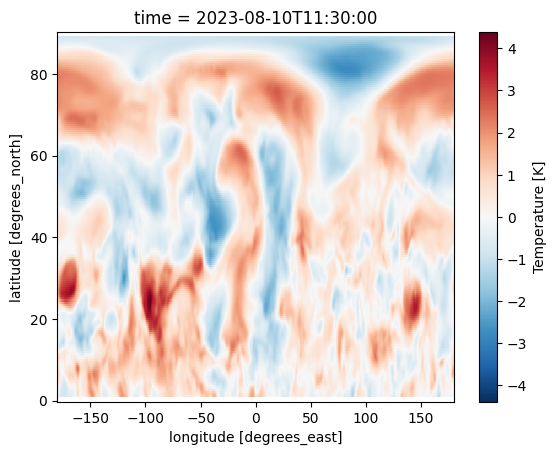

In [30]:
##### Smoothing spatially
smooth_passes=5
matExt_smooth = calculate_smoothed_field(
        matExt, smooth_passes, time_name='time', lat_name='lat', lon_name='lon')
# Rename the DataArray
matExt_smooth= matExt_smooth.rename(dvar)
#matExt_smooth

#snap=matExt.sel(time='2023-08-10',drop=True)
snap=matExt_smooth.sel(time='2023-08-10',drop=True)
snap.plot()

/users/edolores/.env_icon/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:1620: RuntimeWarning: All-NaN slice encountered
  return fnb._ureduce(a,


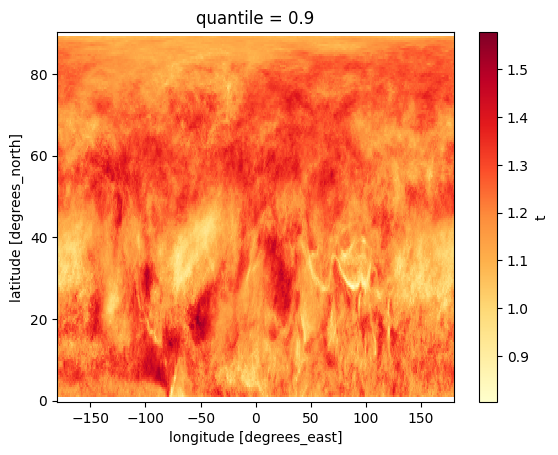

In [31]:
#q90 =matExt.quantile(0.9, dim="time")
q90 =matExt_smooth.quantile(0.9, dim="time")
q90.plot(cmap='YlOrRd')

In [32]:
### specific day showing regions above the 90th percentile 
#snap.isel(time=0,level=0)
#q90

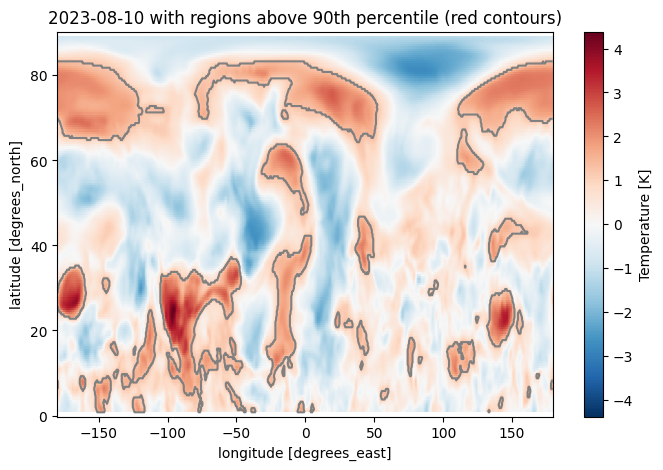

In [34]:
# Start plot of the field
fig, ax = plt.subplots(figsize=(8, 5))
snap.plot(ax=ax, cmap="RdBu_r")  # base field

# Overlay contour line(s) where values exceed q90
(snap.isel(time=0, drop=True) > q90).plot.contour(ax=ax, colors="grey", linewidths=1.5) #t2m

plt.title("2023-08-10 with regions above 90th percentile (red contours)")
plt.show()

In [35]:
##### Save binary files 1/0

In [36]:
#binary=xr.where ( matExt> q90, 1, 0)
binary=xr.where ( matExt_smooth> q90, 1, 0)

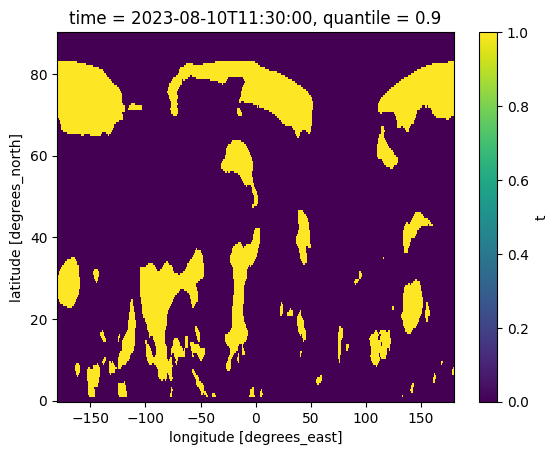

In [37]:
binary.sel(time='2023-08-10',drop=True).plot()

In [38]:
### Track heatwaves
### For pressure level temperature
#binary=binary.isel(level=0,drop=True)

#outpath='/capstor/scratch/cscs/edolores/OBS/ERA5/Heatwaves/MA_TS/'
outpath='/capstor/scratch/cscs/edolores/OBS/ERA5/Heatwaves/MA_T850/'

In [39]:
### intitate
anom = contrack()
anom.read_xarray(binary.to_dataset())

### this block is needed in ALPS
def _get_resolution_patched(self, dim, force=False):
    # Try to get a pandas Index (DatetimeIndex, Float64Index, etc.)
    idx = self.ds[dim].to_index()

    # Case 1: time-like coordinate → return timedelta64[h]
    if isinstance(idx, (pd.DatetimeIndex, pd.TimedeltaIndex)):
        diffs = idx[1:] - idx[:-1]  # TimedeltaIndex
        delta = np.unique(diffs.to_numpy(dtype='timedelta64[h]'))
        return delta[0]

    # Case 2: numeric coordinate (e.g., degrees) → return float
    # (Work directly with numpy array to be robust to Index subclasses)
    arr = np.asarray(idx, dtype=float)
    diffs = np.diff(arr)
    # protect against tiny numerical noise
    delta = np.unique(np.round(diffs, 10))
    return float(delta[0])


# apply the patch
contrack._get_resolution = _get_resolution_patched
##########################################

anom.set_up(force=True)
anom.ds=anom.ds.compute()

/users/edolores/.env_icon/lib/python3.12/site-packages/contrack/contrack.py:129: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  return self.ds.dims[self._get_name_time()]
INFO: 
 time: 'time'
 longitude: 'lon'
 latitude: 'lat'



In [40]:
# Finally, track temperature anomalies (>=1, 50% overlap twosided, 3 timesteps persistence (here 3 days))
anom.run_contrack(variable=dvar,
                   threshold=1,
                   gorl='>=',
                   overlap=0.5,
                   persistence=3,
                   twosided=True)

### save blobs 
anom.to_netcdf(outpath+'/HW_ERA5_NH_20202023_AMJJASO_daily_MA.nc')

INFO: 
Run ConTrack 
########### 
    threshold:    >= 1 
    overlap:      0.5 
    persistence:  3 time steps
INFO: Set up dimensions...
INFO: 
 time: 'time'
 longitude: 'lon'
 latitude: 'lat'

INFO: Find individual contours...
INFO: Apply overlap...
/users/edolores/.env_icon/lib/python3.12/site-packages/contrack/contrack.py:704: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  weight_grid = np.ones((self.ds.dims[self._latitude_name], self.ds.dims[self._longitude_name])) * np.array((111 * self._dlat * 111 * self._dlon * weight_lat)).astype(np.float32)[:, None]
INFO: Apply persistence...
INFO: Create new variable 'flag'...
INFO: Running contrack... DONE
264 contours tracked
/tmp/ipykernel_79430/1008747178.py:10: UserWarning: Times can't be serialized faithfully to int64 with requested unit

In [41]:
### lifecycle
anom_df = anom.run_lifecycle(flag='flag', variable=dvar)
anom_df.to_csv(outpath+'/HW_ERA5_NH_20202023_AMJJASO_daily_MA.csv', index=False)

INFO: 
Run Lifecycle 
########### 
    flag:    flag
    variable:    t
INFO: Set up dimensions...
INFO: 
 time: 'time'
 longitude: 'lon'
 latitude: 'lat'

/users/edolores/.env_icon/lib/python3.12/site-packages/contrack/contrack.py:848: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  weight_grid = np.ones((self.ds.dims[self._latitude_name], self.ds.dims[self._longitude_name])) * np.array((111 * self._dlat * 111 * self._dlon * weight_lat)).astype(np.float32)[:, None]
/users/edolores/.env_icon/lib/python3.12/site-packages/contrack/contrack.py:860: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  

In [42]:
###Frequency
mean_hw = xr.where(anom['flag']>1,1,0).mean(dim='time')*100
#mean_hw.plot(cmap='YlOrRd', levels=np.arange(0, 5, 0.5))

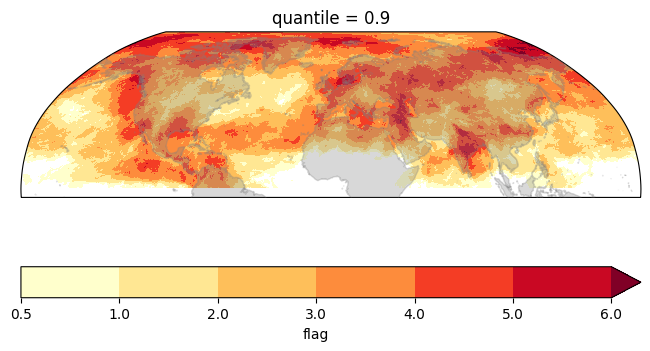

In [43]:
proj = ccrs.Robinson(central_longitude=0, globe=None)

fig, ax1 = plt.subplots(1, 1, figsize=(8, 6), dpi=100, subplot_kw={'projection': proj})
plot=mean_hw.plot(ax=ax1, cmap='YlOrRd', levels=[0.5,1,2,3,4,5,6],transform=ccrs.PlateCarree(),extend="max",cbar_kwargs={"orientation":"horizontal"})
# Add features
ax1.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', 
                                            edgecolor='face', facecolor='grey', alpha=0.30), zorder=20)

In [47]:
# output is a pandas.DataFrame
print(anom_df)
anom_df['Longitude2'] = np.where(anom_df['Longitude'] < 0, anom_df['Longitude']+360,anom_df['Longitude'])

         Flag         Date  Longitude  Latitude  Intensity        Size
0          55  19590501_09       -102        42        1.0  3130479.94
1          55  19590502_09        -94        44        1.0  3013854.59
2          55  19590503_09        -89        43        1.0  3298888.47
3          55  19590504_09        -86        45        1.0  3560882.95
4          55  19590505_09        -83        49        1.0  3718493.83
...       ...          ...        ...       ...        ...         ...
21974  556946  20220929_09       -126        25        1.0  1844949.16
21975  556946  20220930_09       -129        23        1.0  1696788.80
21976  556957  20220928_09        120        42        1.0  3291054.40
21977  556957  20220929_09        119        40        1.0  2899576.03
21978  556957  20220930_09        125        41        1.0  3302248.70

[21979 rows x 6 columns]


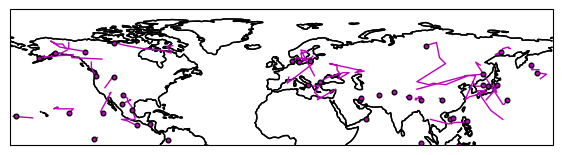

In [48]:
# plotting blocking track (center of mass) and genesis
#f, ax = plt.subplots(1, 1, figsize=(7,5), subplot_kw=dict(projection=ccrs.NorthPolarStereo()))
f, ax = plt.subplots(1, 1, figsize=(7,5), subplot_kw=dict(projection=ccrs.PlateCarree()))
ax.set_extent([-180, 180, 0, 90], crs=ccrs.PlateCarree()); ax.coastlines()
ax.coastlines() # add coastlines
#need to split each blocking track due to longitude wrapping (jumping at map edge)
for bid in np.unique(np.asarray(anom_df['Flag'][12000:12200])): #select blocking id
    lons = np.asarray(anom_df['Longitude2'].iloc[np.where(anom_df['Flag']==bid)])
    lats = np.asarray(anom_df['Latitude'].iloc[np.where(anom_df['Flag']==bid)])

    # cosmetic: sometimes there is a gap near map edge where track is split:
    lons[lons >= 355] = 359.9
    lons[lons <= 3] = 0.1
    segment = np.vstack((lons,lats))

    #move longitude into the map region and split if longitude jumps by more than "threshold"
    lon0 = 0 #center of map
    bleft = lon0-0.
    bright = lon0+360
    segment[0,segment[0]> bright] -= 360
    segment[0,segment[0]< bleft]  += 360
    threshold = 180  # CHANGE HERE
    isplit = np.nonzero(np.abs(np.diff(segment[0])) > threshold)[0]
    subsegs = np.split(segment,isplit+1,axis=+1)

    #plot the tracks
    for seg in subsegs:
        x,y = seg[0],seg[1]
        ax.plot(x ,y,c = 'm',linewidth=1, transform=ccrs.PlateCarree())
    #plot the starting points
    ax.scatter(lons[0],lats[0],s=11,c='m', zorder=10, edgecolor='black', transform=ccrs.PlateCarree())

# Analyzing results

In [38]:
### Plot case study on June 27, 2021

In [48]:
###LOAD ERA5 heatwaves
#anom_era5=xr.open_dataset('/capstor/scratch/cscs/edolores/OBS/ERA5/Heatwaves/MA_TS/HW_ERA5_NH_19592023_AMJJASO_daily_MA.nc')
anom_era5=xr.open_dataset('/capstor/scratch/cscs/edolores/OBS/ERA5/Heatwaves/MA_TS/HW_ERA5_NH_20202023_AMJJASO_daily_MA.nc')
#anom_era5=anom_era5.sel(time=slice('2020','2023'))

In [49]:
# (a) number of heatwave days per year
hw_mask =  xr.where(anom_era5['flag']>1,1,0)
hw_days_per_year = hw_mask.resample(time="YS").sum("time")
hw_days_per_year.name = "heatwave_days"
#hw_days_per_year

In [50]:
mean_hw_days=hw_days_per_year.mean(dim='time')#.plot()#levels=np.arange(0,30,3))

/tmp/ipykernel_79430/2573103684.py:25: DeprecationWarning: The 'shapely.vectorized.contains' function is deprecated and will be removed a future version. Use 'shapely.contains_xy' instead (available since shapely 2.0.0).
  mask_np |= sv.contains(g, xv, yv)


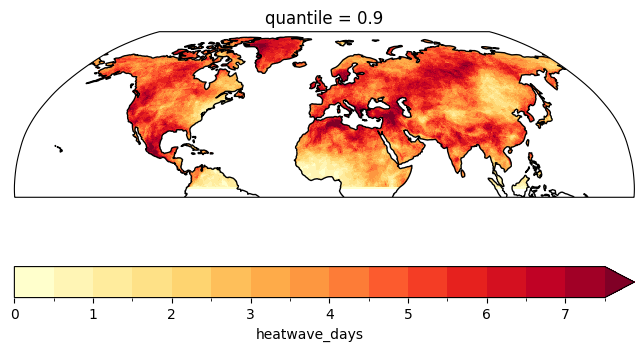

In [51]:
## masking

# --- names of coords ---
lat_name = next(n for n in mean_hw_days.coords if n.lower().startswith('lat'))
lon_name = next(n for n in mean_hw_days.coords if n.lower().startswith('lon'))

# --- 2D lon/lat matching your DataArray's grid & dim order ---
# These come back with dims ordered consistently (use them!)
lon2d, lat2d = xr.broadcast(mean_hw_days[lon_name], mean_hw_days[lat_name])

# Wrap to [-180, 180] for polygon tests
lon_wrapped = ((lon2d + 180) % 360) - 180

# --- Read Natural Earth land polygons (path -> Reader -> geometries) ---
shapefile = shpreader.natural_earth(resolution='110m', category='physical', name='land')
reader = shpreader.Reader(shapefile)
geoms = list(reader.geometries())

# --- Build mask with EXACTLY the same dims/coords as lon2d/lat2d ---
mask_np = np.zeros(lon2d.shape, dtype=bool)
# Use .values so shapely gets numpy arrays
xv = lon_wrapped.values
yv = lat2d.values
for g in geoms:
    mask_np |= sv.contains(g, xv, yv)

mask_da = xr.DataArray(
    mask_np,
    coords={lat_name: lat2d[lat_name], lon_name: lon2d[lon_name]},
    dims=lat2d.dims,  # keep the same dim order as broadcast gave us
)

# If your field has extra dims (e.g., time), broadcast mask to match
mask_da, _ = xr.broadcast(mask_da, mean_hw_days)

# --- Apply mask & plot ---
mean_hw_days_land = mean_hw_days.where(mask_da)

proj = ccrs.Robinson(central_longitude=0)
fig, ax1 = plt.subplots(1, 1, figsize=(8, 6), dpi=100, subplot_kw={'projection': proj})

plot = mean_hw_days_land.plot(
    ax=ax1,
    cmap='YlOrRd',
    levels=np.arange(0, 8, 0.5),
    transform=ccrs.PlateCarree(),
    extend="max",
    cbar_kwargs={"orientation": "horizontal"}
)
ax1.coastlines()
#ax1.set_global()

In [54]:
###LOAD ERA5 heatwaves t850
#anom_era5_t850=xr.open_dataset('/capstor/scratch/cscs/edolores/OBS/ERA5/Heatwaves/MA_T850/HW_ERA5_NH_19592023_AMJJASO_daily_MA.nc')
##last year climatology
anom_era5_t850=xr.open_dataset('/capstor/scratch/cscs/edolores/OBS/ERA5/Heatwaves/MA_T850/HW_ERA5_NH_20202023_AMJJASO_daily_MA.nc')
#anom_era5_t850=anom_era5.sel(time=slice('2019','2023'))

In [55]:
# (a) number of heatwave days per year
hw_mask_t850 =  xr.where(anom_era5_t850['flag']>1,1,0)
hw_days_per_year_t850 = hw_mask_t850.resample(time="YS").sum("time")
hw_days_per_year_t850.name = "heatwave_days"
mean_hw_days_t850=hw_days_per_year_t850.mean(dim='time')#.plot()#levels=np.arange(0,30,3))

/tmp/ipykernel_79430/2809814671.py:25: DeprecationWarning: The 'shapely.vectorized.contains' function is deprecated and will be removed a future version. Use 'shapely.contains_xy' instead (available since shapely 2.0.0).
  mask_np |= sv.contains(g, xv, yv)


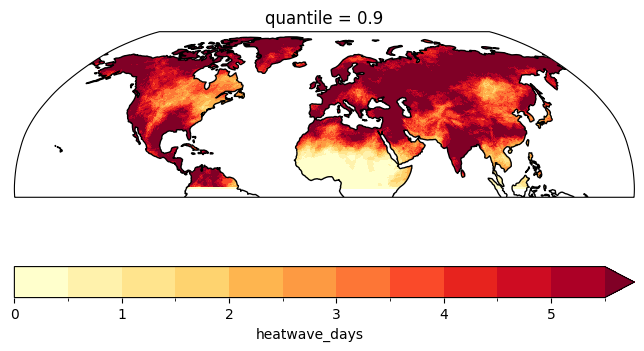

In [56]:
## masking

# --- names of coords ---
lat_name = next(n for n in mean_hw_days.coords if n.lower().startswith('lat'))
lon_name = next(n for n in mean_hw_days.coords if n.lower().startswith('lon'))

# --- 2D lon/lat matching your DataArray's grid & dim order ---
# These come back with dims ordered consistently (use them!)
lon2d, lat2d = xr.broadcast(mean_hw_days[lon_name], mean_hw_days[lat_name])

# Wrap to [-180, 180] for polygon tests
lon_wrapped = ((lon2d + 180) % 360) - 180

# --- Read Natural Earth land polygons (path -> Reader -> geometries) ---
shapefile = shpreader.natural_earth(resolution='110m', category='physical', name='land')
reader = shpreader.Reader(shapefile)
geoms = list(reader.geometries())

# --- Build mask with EXACTLY the same dims/coords as lon2d/lat2d ---
mask_np = np.zeros(lon2d.shape, dtype=bool)
# Use .values so shapely gets numpy arrays
xv = lon_wrapped.values
yv = lat2d.values
for g in geoms:
    mask_np |= sv.contains(g, xv, yv)

mask_da = xr.DataArray(
    mask_np,
    coords={lat_name: lat2d[lat_name], lon_name: lon2d[lon_name]},
    dims=lat2d.dims,  # keep the same dim order as broadcast gave us
)

# If your field has extra dims (e.g., time), broadcast mask to match
mask_da, _ = xr.broadcast(mask_da, mean_hw_days)

# --- Apply mask & plot ---
mean_hw_days_land_t850 = mean_hw_days_t850.where(mask_da)

proj = ccrs.Robinson(central_longitude=0)
fig, ax1 = plt.subplots(1, 1, figsize=(8, 6), dpi=100, subplot_kw={'projection': proj})

plot = mean_hw_days_land_t850.plot(
    ax=ax1,
    cmap='YlOrRd',
    levels=np.arange(0, 6, 0.5),
    transform=ccrs.PlateCarree(),
    extend="max",
    cbar_kwargs={"orientation": "horizontal"}
)
ax1.coastlines()
#ax1.set_global()

In [57]:
### Plot case study on June 27, 2021
#hw_mask.sel(time='2021-06-27').plot()
#hw_mask_t850.sel(time='2021-06-27').plot()


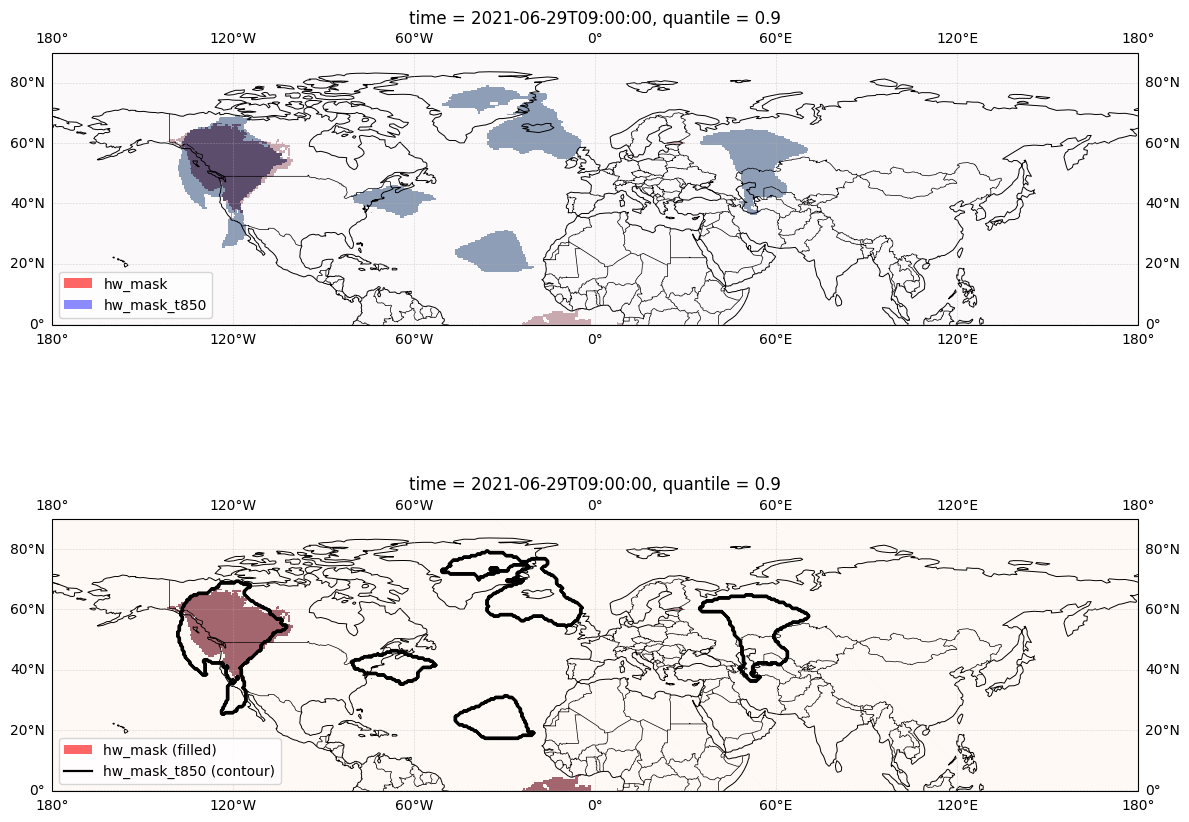

In [64]:

# --- settings ---
date = "2021-06-29"
proj = ccrs.PlateCarree()  # change if your data are on a different CRS

# Pull slices
m1 = hw_mask.sel(time=date).squeeze()
m2 = hw_mask_t850.sel(time=date).squeeze()

# (Optional) align grids if lon/lat differ slightly
# This keeps m1's grid and interpolates m2 to it (comment out if not needed)
if not (m1.lon.equals(m2.lon) and m1.lat.equals(m2.lat)):
    try:
        m2 = m2.interp(lon=m1.lon, lat=m1.lat)
    except Exception:
        # fallback if your coords are named differently
        m2 = m2.interp({m2.dims[-1]: m1[m1.dims[-1]], m2.dims[-2]: m1[m1.dims[-2]]})

# Choose distinct colors
cmap1 = "Reds"
cmap2 = "Blues"

fig = plt.figure(figsize=(12, 10))

# --- A) Same-map overlay with transparency ---
ax1 = plt.subplot(2, 1, 1, projection=proj)
ax1.set_title(f"Overlay (alpha) — {date}", fontsize=12)
ax1.coastlines(linewidth=0.7)
ax1.add_feature(cfeature.BORDERS.with_scale("50m"), linewidth=0.5)
ax1.gridlines(draw_labels=True, linestyle=":", linewidth=0.4)

# base mask (e.g., 2D boolean/int). Use vmin/vmax to keep colors clean.
h1 = m1.plot(
    ax=ax1,
    transform=proj,
    cmap=cmap1,
    add_colorbar=False,
    alpha=0.6,
    vmin=m1.min().item() if m1.dtype.kind != "b" else 0,
    vmax=m1.max().item() if m1.dtype.kind != "b" else 1,
)

# overlay mask with transparency
h2 = m2.plot(
    ax=ax1,
    transform=proj,
    cmap=cmap2,
    add_colorbar=False,
    alpha=0.45,
    vmin=m2.min().item() if m2.dtype.kind != "b" else 0,
    vmax=m2.max().item() if m2.dtype.kind != "b" else 1,
)

legend_alpha = [
    Patch(facecolor="red", alpha=0.6, label="hw_mask"),
    Patch(facecolor="blue", alpha=0.45, label="hw_mask_t850"),
]
ax1.legend(handles=legend_alpha, loc="lower left")

# --- B) Same-map overlay with contours for the second mask ---
ax2 = plt.subplot(2, 1, 2, projection=proj)
ax2.set_title(f"Overlay (contour for second mask) — {date}", fontsize=12)
ax2.coastlines(linewidth=0.7)
ax2.add_feature(cfeature.BORDERS.with_scale("50m"), linewidth=0.5)
ax2.gridlines(draw_labels=True, linestyle=":", linewidth=0.4)

# filled base
m1.plot(
    ax=ax2,
    transform=proj,
    cmap=cmap1,
    add_colorbar=False,
    alpha=0.6,
    vmin=m1.min().item() if m1.dtype.kind != "b" else 0,
    vmax=m1.max().item() if m1.dtype.kind != "b" else 1,
)

# contour of the second mask
# If masks are boolean, a single level at 0.5 outlines the 1s region.
levels = [0.5] if m2.dtype.kind == "b" else None
cont = m2.plot.contour(
    ax=ax2,
    transform=proj,
    levels=levels,
    linewidths=1.6,
    colors="k",
    add_colorbar=False,
)

legend_ct = [
    Patch(facecolor="red", alpha=0.6, label="hw_mask (filled)"),
    Line2D([0], [0], color="k", lw=1.6, label="hw_mask_t850 (contour)"),
]
ax2.legend(handles=legend_ct, loc="lower left")

plt.tight_layout()
#plt.show()


In [58]:
###LOAD ICON heatwaves
#TS
#anom_icon=xr.open_dataset('/capstor/scratch/cscs/edolores/EXCLAIM/ICON_2KM/Heatwaves/MA_TS/HW_ICON_NH_20202024_AMJJASO_daily_MA.nc')
#anom_icon=xr.open_dataset('/capstor/scratch/cscs/edolores/EXCLAIM/ICON_2KM/Heatwaves/MA_TS/HW_ICON_NH_20202024_AMJJASO_daily_MA_simclim.nc')
###T850
anom_icon=xr.open_dataset('/capstor/scratch/cscs/edolores/EXCLAIM/ICON_2KM/Heatwaves/MA_T850/HW_ICON_NH_20202024_AMJJASO_daily_MA_simclim.nc')

#anom_era5.sel(time=slice('2019','2023'))

In [59]:
# (a) number of heatwave days per year
hw_mask_icon =  xr.where(anom_icon['flag']>1,1,0)
hw_days_per_year_icon = hw_mask_icon.resample(time="YS").sum("time")
hw_days_per_year_icon.name = "heatwave_days"
#hw_days_per_year

mean_hw_days_icon=hw_days_per_year_icon.mean(dim='time')#.plot()#levels=np.arange(0,30,3))

/tmp/ipykernel_79430/3670138771.py:27: DeprecationWarning: The 'shapely.vectorized.contains' function is deprecated and will be removed a future version. Use 'shapely.contains_xy' instead (available since shapely 2.0.0).
  mask_np |= sv.contains(g, xv, yv)


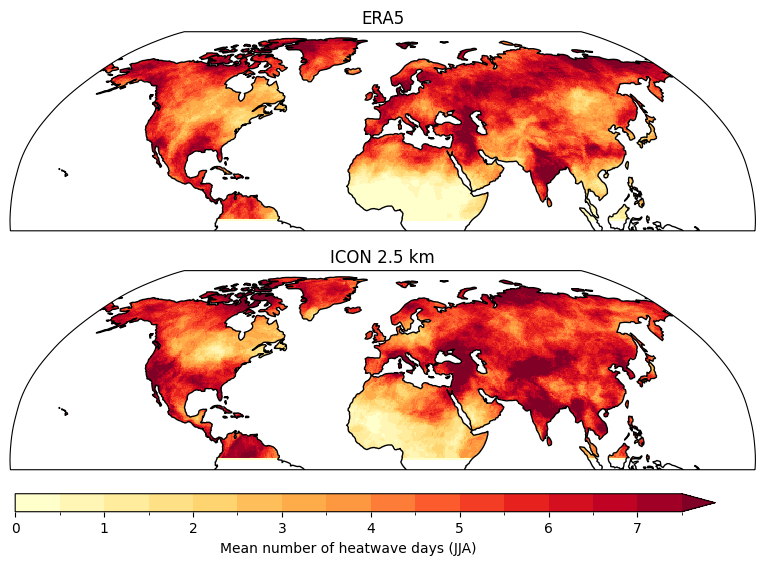

In [61]:
## masking
sufix='JJA'
domain='NH'

# --- names of coords ---
lat_name = next(n for n in mean_hw_days.coords if n.lower().startswith('lat'))
lon_name = next(n for n in mean_hw_days.coords if n.lower().startswith('lon'))

# --- 2D lon/lat matching your DataArray's grid & dim order ---
# These come back with dims ordered consistently (use them!)
lon2d, lat2d = xr.broadcast(mean_hw_days[lon_name], mean_hw_days[lat_name])

# Wrap to [-180, 180] for polygon tests
lon_wrapped = ((lon2d + 180) % 360) - 180

# --- Read Natural Earth land polygons (path -> Reader -> geometries) ---
shapefile = shpreader.natural_earth(resolution='110m', category='physical', name='land')
reader = shpreader.Reader(shapefile)
geoms = list(reader.geometries())

# --- Build mask with EXACTLY the same dims/coords as lon2d/lat2d ---
mask_np = np.zeros(lon2d.shape, dtype=bool)
# Use .values so shapely gets numpy arrays
xv = lon_wrapped.values
yv = lat2d.values
for g in geoms:
    mask_np |= sv.contains(g, xv, yv)

mask_da = xr.DataArray(
    mask_np,
    coords={lat_name: lat2d[lat_name], lon_name: lon2d[lon_name]},
    dims=lat2d.dims,  # keep the same dim order as broadcast gave us
)

# If your field has extra dims (e.g., time), broadcast mask to match
mask_da, _ = xr.broadcast(mask_da, mean_hw_days)

# --- Apply mask & plot ---
mean_hw_days_land_icon = mean_hw_days_icon.where(mask_da)

### Plot ERA5 and ICON 2.5 km
# Projection
proj = ccrs.Robinson(central_longitude=0)

# Create figure and axes
fig, axes = plt.subplots(
    2, 1, figsize=(14, 6), dpi=100,
    subplot_kw={'projection': proj}
)

# Common settings
levels = np.arange(0, 8, 0.5)
cmap = 'YlOrRd'

# --- ERA5 ---
#p1 = mean_hw_days_land.plot(
p1 = mean_hw_days_land_t850.plot(
    ax=axes[0],
    cmap=cmap,
    levels=levels,
    transform=ccrs.PlateCarree(),
    extend='max',
    add_colorbar=False
)
axes[0].coastlines()
axes[0].set_title('ERA5')

# --- ICON 2.5 km ---
p2 = mean_hw_days_land_icon.plot(
    ax=axes[1],
    cmap=cmap,
    levels=levels,
    transform=ccrs.PlateCarree(),
    extend='max',
    add_colorbar=False
)
axes[1].coastlines()
axes[1].set_title('ICON 2.5 km')

# Adjust subplot spacing to make room for colorbar
fig.subplots_adjust(bottom=0.15, wspace=0.05)

# Add horizontal colorbar below both plots
cbar_ax = fig.add_axes([0.25, 0.08, 0.5, 0.03])  # [left, bottom, width, height]
cbar = fig.colorbar(p2, cax=cbar_ax, orientation='horizontal', pad= 0.05,shrink=0.8,aspect=40)
cbar.set_label('Mean number of heatwave days (JJA)')

#plt.savefig(dir_figures+'Heatwave_days_PerBlob_'+sufix+'_'+domain+'.jpg',dpi=300, facecolor='white', bbox_inches='tight', pad_inches=0)

In [68]:
# full
#over land
hw_days_land_icon = hw_days_per_year_icon.where(mask_da)
#hw_days_land_icon.sel(time=slice('2020','2023')).mean(dim=['lat','lon']).plot()

hw_days_land = hw_days_per_year.where(mask_da)
#hw_days_land.sel(time=slice('2000','2023')).mean(dim=['lat','lon']).plot()

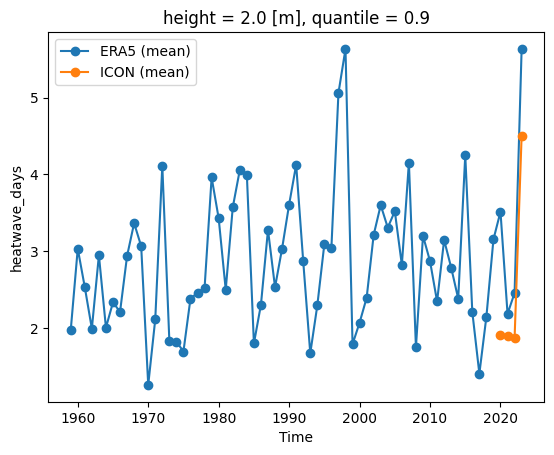

In [69]:

# Create a single figure and axis
fig, ax = plt.subplots()

## Full
hw_days_per_year.sel(time=slice('1959','2023')).mean(dim=['lat', 'lon']).plot(ax=ax, marker='o', label='ERA5 (mean)')
hw_days_per_year_icon.sel(time=slice('2020','2023')).mean(dim=['lat', 'lon']).plot(ax=ax, marker='o', label='ICON (mean)')

## mean over land
#hw_days_land.sel(time=slice('2000','2023')).mean(dim=['lat', 'lon']).plot(ax=ax, marker='o', label='ERA5 (mean)')
#hw_days_land_icon.sel(time=slice('2020','2023')).mean(dim=['lat', 'lon']).plot(ax=ax, marker='o', label='ICON (mean)')

ax.set_xlabel('Time')
ax.legend()

# Tracks and properties

/tmp/ipykernel_228203/3799743616.py:102: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bplot = ax.boxplot(data, patch_artist=True, labels=labels,


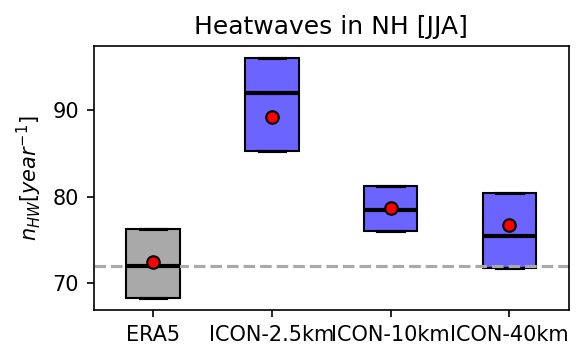

In [4]:
#### Select domain and period
domain='NH' ### PAC, ATL, NH, SH
sufix='JJA' ### YEAR, DJF, JJA

if sufix == 'DJF':
    months = ['12', '01', '02']
elif sufix == 'JJA':
    months = ['06', '07', '08']
elif sufix == 'YEAR':
    months = ['01','02','03','04','05','06', '07', '08','09','10','11','12']
else:
    raise ValueError(f"Invalid season suffix: {sufix}")
    
# Get CSV files list from a folder
###ICON 2km
#file = '/capstor/scratch/cscs/edolores/EXCLAIM/ICON_2KM/Heatwaves/MA_TS/HW_ICON_NH_19592023_AMJJASO_daily_MA.csv'
file = '/capstor/scratch/cscs/edolores/EXCLAIM/ICON_2KM/Heatwaves/MA_TS/HW_ICON_NH_19592023_AMJJASO_daily_MA_simclim.csv'
icon_df_2km = pd.read_csv(file)
icon_df_2km['year']=icon_df_2km.Date.str[:4]
icon_df_2km['month']=icon_df_2km.Date.str[4:6]
icon_df_2km = icon_df_2km[icon_df_2km['year'].isin( ['2020', '2021', '2022','2023'])]

###ICON 10km
#file = '/capstor/scratch/cscs/edolores/EXCLAIM/ICON_2KM/Heatwaves/MA_TS/HW_ICON_NH_19592023_AMJJASO_daily_MA.csv'
file = '/capstor/scratch/cscs/edolores/icon-climate-dt/Heatwaves/MA_TS/HW_ICON_NH_19592023_AMJJASO_daily_MA_simclim.csv'
icon_df_10km = pd.read_csv(file)
icon_df_10km['year']=icon_df_10km.Date.str[:4]
icon_df_10km['month']=icon_df_10km.Date.str[4:6]
icon_values_10km = icon_df_10km.groupby('Flag').size().reset_index(name='Duration')
icon_df_10km = icon_df_10km.merge(icon_values_10km, on='Flag', how='left')

###ICON 40km
#file = '/capstor/scratch/cscs/edolores/old_icon/Heatwaves/MA_TS/HW_ICON_NH_19592023_AMJJASO_daily_MA.csv'
file = '/capstor/scratch/cscs/edolores/old_icon/Heatwaves/MA_TS/HW_ICON_NH_19592023_AMJJASO_daily_MA_simclim.csv'
icon_df_40km = pd.read_csv(file)
icon_df_40km['year']=icon_df_40km.Date.str[:4]
icon_df_40km['month']=icon_df_40km.Date.str[4:6]
icon_values_40km = icon_df_40km.groupby('Flag').size().reset_index(name='Duration')
icon_df_40km = icon_df_40km.merge(icon_values_40km, on='Flag', how='left')

##ERA5
#file = '/capstor/scratch/cscs/edolores/OBS/ERA5/Heatwaves/MA_TS/HW_ERA5_NH_19592023_AMJJASO_daily_MA.csv'
file = '/capstor/scratch/cscs/edolores/OBS/ERA5/Heatwaves/MA_TS/HW_ERA5_NH_20202023_AMJJASO_daily_MA.csv'
era5_df = pd.read_csv(file)
era5_df['year']=era5_df.Date.str[:4]
era5_df['month']=era5_df.Date.str[4:6]
### Select 5 years only
#era5_df = era5_df[era5_df['year'].isin( ['2020', '2021', '2022','2023'])]

### filter domain
if domain == 'NH':
    icon_df_2km = icon_df_2km[(icon_df_2km['Latitude'] > 0 )]
    icon_df_10km = icon_df_10km[(icon_df_10km['Latitude'] > 0 )]
    icon_df_40km = icon_df_40km[(icon_df_40km['Latitude'] > 0 )]
    era5_df = era5_df[(era5_df['Latitude'] > 0 )]
if domain == 'ATL':
    icon_df_2km = icon_df_2km[(icon_df_2km['Latitude'] > 0 ) & (icon_df_2km['Longitude'] > -90 ) & (icon_df_2km['Longitude'] < 90 )]
    icon_df_10km = icon_df_10km[(icon_df_10km['Latitude'] > 0 ) & (icon_df_10km['Longitude'] > -90 ) & (icon_df_10km['Longitude'] < 90 )]
    icon_df_40km = icon_df_40km[(icon_df_40km['Latitude'] > 0 ) & (icon_df_40km['Longitude'] > -90 ) & (icon_df_40km['Longitude'] < 90 )]
    era5_df = era5_df[(era5_df['Latitude'] > 0)  & (era5_df['Longitude'] > -90 ) & (era5_df['Longitude'] < 90 )]
if domain == 'PAC':
    icon_df_2km = icon_df_2km[(icon_df_2km['Latitude'] > 0 ) & ((icon_df_2km['Longitude'] > 90 ) | (icon_df_2km['Longitude'] < -90 ))]
    icon_df_10km = icon_df_10km[(icon_df_10km['Latitude'] > 0 ) & ((icon_df_10km['Longitude'] > 90 ) | (icon_df_10km['Longitude'] < -90 ))]
    icon_df_40km = icon_df_40km[(icon_df_40km['Latitude'] > 0 ) & ((icon_df_40km['Longitude'] > 90 ) | (icon_df_40km['Longitude'] < -90 ))]
    era5_df = era5_df[(era5_df['Latitude'] > 0)  & ((era5_df['Longitude'] > 90) | (era5_df['Longitude'] < -90))]
if domain == 'SH':
    icon_df_2km = icon_df_2km[(icon_df_2km['Latitude'] < 0 )]
    icon_df_10km = icon_df_10km[(icon_df_10km['Latitude'] < 0 )]
    icon_df_40km = icon_df_40km[(icon_df_40km['Latitude'] < 0 )]
    era5_df = era5_df[(era5_df['Latitude'] < 0 )]

### select season
icon_df_2km = icon_df_2km[icon_df_2km['month'].isin(months)]
icon_df_10km = icon_df_10km[icon_df_10km['month'].isin(months)]
icon_df_40km = icon_df_40km[icon_df_40km['month'].isin(months)]
era5_df = era5_df[era5_df['month'].isin(months)]

# Color definitions
color_icon = '#6b64ff'
color_era5 = 'darkgrey'
color_cmip6 = '#db6f30'

# Sample DataFrame simulation
era5_values = era5_df.groupby('year')['Flag'].nunique().values
icon_values_2km = icon_df_2km.groupby('year')['Flag'].nunique().values
icon_values_10km = icon_df_10km.groupby('year')['Flag'].nunique().values
icon_values_40km = icon_df_40km.groupby('year')['Flag'].nunique().values

data = [era5_values, icon_values_2km, icon_values_10km, icon_values_40km]
labels = ['ERA5', 'ICON-2.5km', 'ICON-10km', 'ICON-40km']
colors = [color_era5, color_icon, color_icon, color_icon]

fig, ax = plt.subplots(figsize=(4, 2.5), dpi=150)

# Boxplot configuration
boxprops = dict(facecolor='white', color='black')  # White box with black borders
medianprops = dict(color='black', linewidth=2)  # Median line
whiskerprops = dict(color='black', linewidth=1.5)  # Whiskers
capprops = dict(color='black', linewidth=1.5)  # Caps on whiskers

# Plot boxplot
bplot = ax.boxplot(data, patch_artist=True, labels=labels, 
                   boxprops=boxprops, medianprops=medianprops,whis=(5, 95),
                   whiskerprops=whiskerprops, capprops=capprops, showmeans=True,showfliers=False,
                   meanprops=dict(marker='o', markerfacecolor='red', markeredgecolor='black', markersize=6))

# Custom colors for boxes
for patch, color in zip(bplot['boxes'], colors):
    patch.set_facecolor(color)

# Calculate and add a horizontal line at the mean of era5_df
mean_era5 = np.median(era5_values)
ax.axhline(mean_era5, color=color_era5, linestyle='--', linewidth=1.5, label=f'ERA5 Median ({mean_era5:.2f})')


ax.set_ylabel('$n_{HW}$[$year^{-1}$]')
ax.set_title('Heatwaves in '+domain+' ['+sufix+']')

plt.tight_layout()

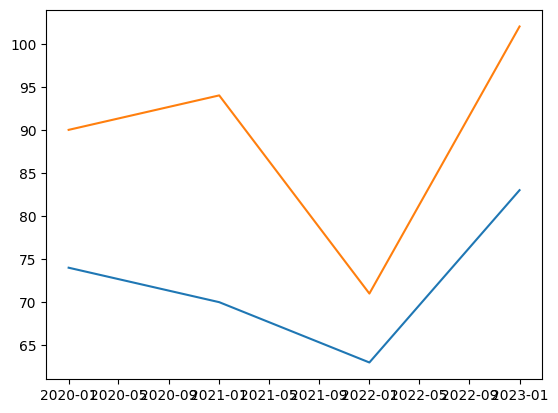

In [5]:
plt.plot(pd.to_datetime(era5_df['year'].unique()),era5_values)
plt.plot(pd.to_datetime(icon_df_2km['year'].unique()),icon_values_2km)

/tmp/ipykernel_228203/1891116203.py:86: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bplot = ax.boxplot(data, patch_artist=True, labels=labels,


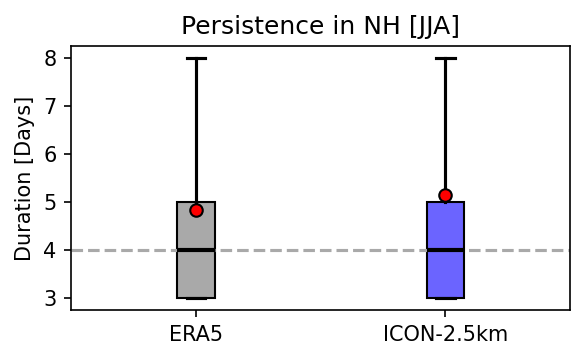

In [6]:
### persistence
#### Select domain and period
domain='NH' ### PAC, ATL, NH, SH
sufix='JJA' ### YEAR, DJF, JJA

if sufix == 'DJF':
    months = ['12', '01', '02']
elif sufix == 'JJA':
    months = ['06', '07', '08']
elif sufix == 'YEAR':
    months = ['01','02','03','04','05','06', '07', '08','09','10','11','12']
else:
    raise ValueError(f"Invalid season suffix: {sufix}")
    
# Get CSV files list from a folder
###ICON 2km
#file = '/capstor/scratch/cscs/edolores/EXCLAIM/ICON_2KM/Heatwaves/MA_TS/HW_ICON_NH_19592023_AMJJASO_daily_MA.csv'
file = '/capstor/scratch/cscs/edolores/EXCLAIM/ICON_2KM/Heatwaves/MA_TS/HW_ICON_NH_19592023_AMJJASO_daily_MA_simclim.csv'
icon_df_2km = pd.read_csv(file)
icon_df_2km['year']=icon_df_2km.Date.str[:4]
icon_df_2km['month']=icon_df_2km.Date.str[4:6]
icon_values_2km = icon_df_2km.groupby('Flag').size().reset_index(name='Duration')
icon_df_2km = icon_df_2km.merge(icon_values_2km, on='Flag', how='left')
### Select 5 years only
icon_df_2km = icon_df_2km[icon_df_2km['year'].isin( ['2020', '2021', '2022','2023'])]

##ERA5
#file = '/capstor/scratch/cscs/edolores/OBS/ERA5/Heatwaves/MA_TS/HW_ERA5_NH_19592023_AMJJASO_daily_MA.csv'
file = '/capstor/scratch/cscs/edolores/OBS/ERA5/Heatwaves/MA_TS/HW_ERA5_NH_20202023_AMJJASO_daily_MA.csv'
era5_df = pd.read_csv(file)
era5_df['year']=era5_df.Date.str[:4]
era5_df['month']=era5_df.Date.str[4:6]
era5_values = era5_df.groupby('Flag').size().reset_index(name='Duration')
era5_df = era5_df.merge(era5_values, on='Flag', how='left')
                        
### Select 5 years only
era5_df = era5_df[era5_df['year'].isin( ['2020', '2021', '2022','2023'])]

### filter domain
if domain == 'NH':
    icon_df_2km = icon_df_2km[(icon_df_2km['Latitude'] > 0 )]
#    ifs_df_9km = ifs_df_9km[(ifs_df_9km['Latitude'] > 0 )]
    era5_df = era5_df[(era5_df['Latitude'] > 0 )]
if domain == 'ATL':
    icon_df_2km = icon_df_2km[(icon_df_2km['Latitude'] > 0 ) & (icon_df_2km['Longitude'] > -90 ) & (icon_df_2km['Longitude'] < 90 )]
#    ifs_df_9km = ifs_df_9km[(ifs_df_9km['Latitude'] > 0 ) & (ifs_df_9km['Longitude'] > -90 ) & (ifs_df_9km['Longitude'] < 90 )]
    era5_df = era5_df[(era5_df['Latitude'] > 0)  & (era5_df['Longitude'] > -90 ) & (era5_df['Longitude'] < 90 )]
if domain == 'PAC':
    icon_df_2km = icon_df_2km[(icon_df_2km['Latitude'] > 0 ) & ((icon_df_2km['Longitude'] > 90 ) | (icon_df_2km['Longitude'] < -90 ))]
#    ifs_df_9km = ifs_df_9km[(ifs_df_9km['Latitude'] > 0 ) & ((ifs_df_9km['Longitude'] > 90 ) | (ifs_df_9km['Longitude'] < -90 ))]
    era5_df = era5_df[(era5_df['Latitude'] > 0)  & ((era5_df['Longitude'] > 90) | (era5_df['Longitude'] < -90))]
if domain == 'SH':
    icon_df_2km = icon_df_2km[(icon_df_2km['Latitude'] < 0 )]
#    ifs_df_9km = ifs_df_9km[(ifs_df_9km['Latitude'] < 0 )]
    era5_df = era5_df[(era5_df['Latitude'] < 0 )]

### select season
icon_df_2km = icon_df_2km[icon_df_2km['month'].isin(months)]
era5_df = era5_df[era5_df['month'].isin(months)]

### keep only unique flags
icon_values_2km = icon_df_2km.drop_duplicates(subset=['Flag']).reset_index(drop=True)
era5_values = era5_df.drop_duplicates(subset=['Flag']).reset_index(drop=True)

# Color definitions
color_icon = '#6b64ff'
color_era5 = 'darkgrey'
color_cmip6 = '#db6f30'

# Sample DataFrame simulation
data = [era5_values['Duration'].values, icon_values_2km['Duration'].values]
labels = ['ERA5', 'ICON-2.5km']
colors = [color_era5, color_icon]

# Create a plot
###
fig, ax = plt.subplots(figsize=(4, 2.5), dpi=150)

# Boxplot configuration
boxprops = dict(facecolor='white', color='black')  # White box with black borders
medianprops = dict(color='black', linewidth=2)  # Median line
whiskerprops = dict(color='black', linewidth=1.5)  # Whiskers
capprops = dict(color='black', linewidth=1.5)  # Caps on whiskers

# Plot boxplot
bplot = ax.boxplot(data, patch_artist=True, labels=labels, 
                   boxprops=boxprops, medianprops=medianprops,whis=(10, 90),
                   whiskerprops=whiskerprops, capprops=capprops, showmeans=True, showfliers=False,
                   meanprops=dict(marker='o', markerfacecolor='red', markeredgecolor='black', markersize=6))

# Custom colors for boxes
for patch, color in zip(bplot['boxes'], colors):
    patch.set_facecolor(color)

# Calculate and add a horizontal line at the mean of era5_df
mean_era5 = np.median(era5_values['Duration'].values)
ax.axhline(mean_era5, color=color_era5, linestyle='--', linewidth=1.5, label=f'ERA5 Mean ({mean_era5:.2f})')


ax.set_ylabel('Duration [Days]')
ax.set_title('Persistence in '+domain+' ['+sufix+']')

plt.tight_layout()

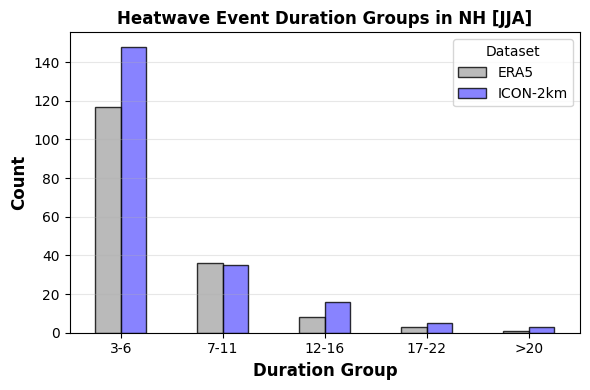

In [7]:
# Define bins and labels
bins = [3, 6, 11, 16, 22, float('inf')]
labels = ['3-6', '7-11', '12-16', '17-22', '>20']

# Apply binning to each dataset
era5_values['Duration Group'] = pd.cut(era5_values['Duration'], bins=bins, labels=labels, right=True)
icon_values_2km['Duration Group'] = pd.cut(icon_values_2km['Duration'], bins=bins, labels=labels, right=True)

# Count occurrences in each group
era5_counts = era5_values['Duration Group'].value_counts().sort_index()
icon_2km_counts = icon_values_2km['Duration Group'].value_counts().sort_index()


# Create a DataFrame to compare counts
duration_df = pd.DataFrame({'ERA5': era5_counts, 'ICON-2km': icon_2km_counts}).fillna(0)

# Define hatching patterns (consistent for each dataset)
hatch_patterns = {'ERA5': None, 'ICON-2km': None,}#'IFS-9km': '/', 'IFS-28km': '\\'}

# Plot grouped bar chart
ax = duration_df.plot(kind='bar', figsize=(6, 4),color=[color_era5, color_icon], alpha=0.8, edgecolor='black')

# Apply hatching consistently per dataset
for bar_container, dataset_name in zip(ax.containers, duration_df.columns):
    for bar in bar_container:
        bar.set_hatch(hatch_patterns[dataset_name])  # Apply consistent hatching

plt.title('Heatwave Event Duration Groups in ' + domain + ' [' + sufix + ']', fontsize=12, weight="bold")
plt.xlabel('Duration Group', fontsize=12, weight="bold")
plt.ylabel('Count', fontsize=12, weight="bold")
plt.legend(title='Dataset')
plt.grid(axis='y', alpha=0.3)
plt.xticks(rotation=0)
plt.tight_layout()

In [8]:
''' 
### A zoom
# Define bins and labels
bins = [12, 16, 22, float('inf')]
labels = ['12-16', '17-22', '>20']

# Apply binning to each dataset
era5_values['Duration Group'] = pd.cut(era5_values['Duration'], bins=bins, labels=labels, right=True)
icon_values_2km['Duration Group'] = pd.cut(icon_values_2km['Duration'], bins=bins, labels=labels, right=True)

# Count occurrences in each group
era5_counts = era5_values['Duration Group'].value_counts().sort_index()
icon_2km_counts = icon_values_2km['Duration Group'].value_counts().sort_index()


# Create a DataFrame to compare counts
duration_df = pd.DataFrame({'ERA5': era5_counts, 'ICON-2km': icon_2km_counts}).fillna(0)

# Define hatching patterns (consistent for each dataset)
hatch_patterns = {'ERA5': None, 'ICON-2km': None,}#'IFS-9km': '/', 'IFS-28km': '\\'}

# Plot grouped bar chart
ax = duration_df.plot(kind='bar', figsize=(6, 4),color=[color_era5, color_icon], alpha=0.8, edgecolor='black')

# Apply hatching consistently per dataset
for bar_container, dataset_name in zip(ax.containers, duration_df.columns):
    for bar in bar_container:
        bar.set_hatch(hatch_patterns[dataset_name])  # Apply consistent hatching

plt.title('Heatwave Event Duration Groups in ' + domain + ' [' + sufix + ']', fontsize=12, weight="bold")
plt.xlabel('Duration Group', fontsize=12, weight="bold")
plt.ylabel('Count', fontsize=12, weight="bold")
plt.legend(title='Dataset')
plt.grid(axis='y', alpha=0.3)
plt.xticks(rotation=0)
plt.tight_layout()
'''

' \n### A zoom\n# Define bins and labels\nbins = [12, 16, 22, float(\'inf\')]\nlabels = [\'12-16\', \'17-22\', \'>20\']\n\n# Apply binning to each dataset\nera5_values[\'Duration Group\'] = pd.cut(era5_values[\'Duration\'], bins=bins, labels=labels, right=True)\nicon_values_2km[\'Duration Group\'] = pd.cut(icon_values_2km[\'Duration\'], bins=bins, labels=labels, right=True)\n\n# Count occurrences in each group\nera5_counts = era5_values[\'Duration Group\'].value_counts().sort_index()\nicon_2km_counts = icon_values_2km[\'Duration Group\'].value_counts().sort_index()\n\n\n# Create a DataFrame to compare counts\nduration_df = pd.DataFrame({\'ERA5\': era5_counts, \'ICON-2km\': icon_2km_counts}).fillna(0)\n\n# Define hatching patterns (consistent for each dataset)\nhatch_patterns = {\'ERA5\': None, \'ICON-2km\': None,}#\'IFS-9km\': \'/\', \'IFS-28km\': \'\\\'}\n\n# Plot grouped bar chart\nax = duration_df.plot(kind=\'bar\', figsize=(6, 4),color=[color_era5, color_icon], alpha=0.8, edgecolor

In [17]:
## over land
# -------- Land tester (once) --------
def build_land_union(resolution="110m"):
    shp = shpreader.natural_earth(resolution=resolution, category='physical', name='land')
    geoms = list(shpreader.Reader(shp).geometries())
    # Merge into a single (Multi)Polygon; buffer(0) to fix minor validity issues
    land_union = sops.unary_union(geoms).buffer(0)
    return land_union

LAND_UNION = build_land_union("110m")

def lon_wrap_180(lon):
    # works for scalar/array/Series
    return ((np.asarray(lon) + 180) % 360) - 180

def flag_land_rows(df, lon_col="Longitude", lat_col="Latitude", epsilon_deg=0.0):
    """
    Returns a boolean numpy array True over land.
    epsilon_deg > 0 (e.g., 0.05) slightly expands land to catch coastlines.
    """
    lonw = lon_wrap_180(df[lon_col].values)
    lat  = df[lat_col].values
    geom = LAND_UNION if epsilon_deg == 0 else LAND_UNION.buffer(epsilon_deg)
    return sv.contains(geom, lonw, lat)  # vectorized

import cartopy.crs as ccrs
import cartopy.feature as cfeature

def split_wrap_segments(lons, lats, jump_deg=180.0):
    """
    Split a polyline whenever the longitude jumps across the dateline.
    lons/lats are in degrees ([-180, 180] recommended).
    Returns list of (lon_segment, lat_segment).
    """
    lons = np.asarray(lons, dtype=float)
    lats = np.asarray(lats, dtype=float)
    # indices where we should split (big jump from point i to i+1)
    jumps = np.where(np.abs(np.diff(lons)) > jump_deg)[0]
    if jumps.size == 0:
        return [(lons, lats)]
    segs = []
    start = 0
    for j in jumps:
        segs.append((lons[start:j+1], lats[start:j+1]))
        start = j + 1
    segs.append((lons[start:], lats[start:]))
    # filter very short segments
    segs = [(x, y) for (x, y) in segs if len(x) >= 2]
    return segs

def select_extent_for_domain(domain):
    if domain == 'NH':
        return [-180, 180, 0, 90]
    if domain == 'SH':
        return [-180, 180, -90, 0]
    if domain == 'ATL':
        return [-90, 90, 0, 90]
    if domain == 'PAC':
        # show both NH Pacific lobes
        return [90, -90 + 360, 0, 90]  # effectively [90, 270, 0, 90]
    return [-180, 180, -90, 90]

def plot_tracks_map(df, *, domain='NH', sufix='JJA',
                    land_condition='any',  # 'any' (touch land), 'start' (genesis on land), or None (ignore land)
                    epsilon_deg=0.02,
                    color='tab:purple', lw=0.8, alpha=0.9,
                    mark_genesis=True, genesis_size=10):
    """
    Plot tracks from a dataframe with columns: Flag, Longitude, Latitude, Date (sortable).
    land_condition:
        'any'   -> keep tracks that touch land at least once (default)
        'start' -> keep tracks whose *first* point* is on land
        None    -> ignore land filtering
    """
    dplot = df.copy()

    # Ensure land flag exists
    if 'on_land' not in dplot.columns:
        dplot['on_land'] = flag_land_rows(dplot, 'Longitude', 'Latitude', epsilon_deg=epsilon_deg)

    if land_condition == 'any':
        flags_on_land = dplot.groupby('Flag')['on_land'].any()
        dplot = dplot[dplot['Flag'].isin(flags_on_land[flags_on_land].index)]
    elif land_condition == 'start':
        # Sort by date within each track
        first_points = dplot.sort_values(['Flag', 'Date']).groupby('Flag').first()
        start_on_land = first_points[first_points['on_land']].index
        dplot = dplot[dplot['Flag'].isin(start_on_land)]

    # Sort so segments are drawn in time order per track
    sort_cols = ['Flag']
    if 'Date' in dplot.columns:
        sort_cols.append('Date')
    dplot = dplot.sort_values(sort_cols)

    # Wrap longitudes to [-180, 180]
    dplot['lonw'] = lon_wrap_180(dplot['Longitude'].values)
    dplot['lat']  = dplot['Latitude'].values

    # Set up map
    fig, ax = plt.subplots(1, 1, figsize=(8, 5),
                           subplot_kw=dict(projection=ccrs.PlateCarree()))
    ax.set_extent(select_extent_for_domain(domain), crs=ccrs.PlateCarree())
    ax.add_feature(cfeature.LAND, facecolor='0.93', edgecolor='none', zorder=0)
    ax.add_feature(cfeature.OCEAN, facecolor='0.98', edgecolor='none', zorder=0)
    ax.coastlines(linewidth=0.7)
    gl = ax.gridlines(draw_labels=True, linewidth=0.3, color='0.6', alpha=0.5, linestyle='--')

    # Draw each track
    for flag, g in dplot.groupby('Flag'):
        lons = g['lonw'].to_numpy()
        lats = g['lat'].to_numpy()
        for seg_lon, seg_lat in split_wrap_segments(lons, lats):
            ax.plot(seg_lon, seg_lat, transform=ccrs.PlateCarree(),
                    linewidth=lw, alpha=alpha, color=color, zorder=2)
        if mark_genesis and len(lons) > 0:
            ax.scatter(lons[0], lats[0], transform=ccrs.PlateCarree(),
                       s=genesis_size, facecolor=color, edgecolor='black',
                       linewidth=0.3, zorder=3)

    condition_str = {
        'any': 'touching land',
        'start': 'starting on land',
        None: 'all tracks'
    }[land_condition]
    ax.set_title(f'ERA5 heatwave tracks {condition_str} — {domain} [{sufix}]')
    plt.tight_layout()
    return fig, ax

/tmp/ipykernel_228203/1647237798.py:24: DeprecationWarning: The 'shapely.vectorized.contains' function is deprecated and will be removed a future version. Use 'shapely.contains_xy' instead (available since shapely 2.0.0).
  return sv.contains(geom, lonw, lat)  # vectorized
/tmp/ipykernel_228203/1647237798.py:24: DeprecationWarning: The 'shapely.vectorized.contains' function is deprecated and will be removed a future version. Use 'shapely.contains_xy' instead (available since shapely 2.0.0).
  return sv.contains(geom, lonw, lat)  # vectorized
/tmp/ipykernel_228203/2371808283.py:83: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bplot = ax.boxplot(


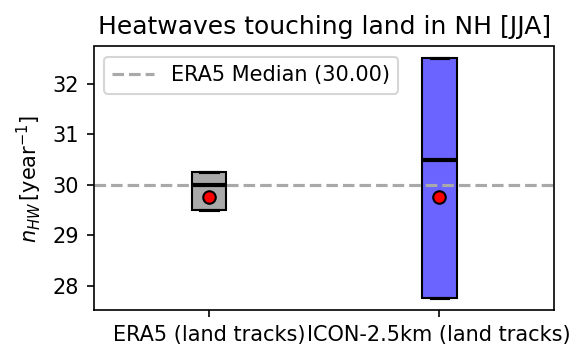

In [10]:
#### Select domain and period
domain='NH' ### PAC, ATL, NH, SH
sufix='JJA' ### YEAR, DJF, JJA

if sufix == 'DJF':
    months = ['12', '01', '02']
elif sufix == 'JJA':
    months = ['06', '07', '08']
elif sufix == 'YEAR':
    months = ['01','02','03','04','05','06', '07', '08','09','10','11','12']
else:
    raise ValueError(f"Invalid season suffix: {sufix}")
    
# Get CSV files list from a folder
###ICON 2km
#file = '/capstor/scratch/cscs/edolores/EXCLAIM/ICON_2KM/Heatwaves/MA_TS/HW_ICON_NH_19592023_AMJJASO_daily_MA.csv'
file = '/capstor/scratch/cscs/edolores/EXCLAIM/ICON_2KM/Heatwaves/MA_TS/HW_ICON_NH_19592023_AMJJASO_daily_MA_simclim.csv'
icon_df_2km = pd.read_csv(file)
icon_df_2km['year']=icon_df_2km.Date.str[:4]
icon_df_2km['month']=icon_df_2km.Date.str[4:6]
icon_df_2km = icon_df_2km[icon_df_2km['year'].isin( ['2020', '2021', '2022','2023'])]

##ERA5
#file = '/capstor/scratch/cscs/edolores/OBS/ERA5/Heatwaves/MA_TS/HW_ERA5_NH_19592023_AMJJASO_daily_MA.csv'
file = '/capstor/scratch/cscs/edolores/OBS/ERA5/Heatwaves/MA_TS/HW_ERA5_NH_20202023_AMJJASO_daily_MA.csv'
era5_df = pd.read_csv(file)
era5_df['year']=era5_df.Date.str[:4]
era5_df['month']=era5_df.Date.str[4:6]
### Select 5 years only
era5_df = era5_df[era5_df['year'].isin( ['2020', '2021', '2022','2023'])]

### filter domain
if domain == 'NH':
    icon_df_2km = icon_df_2km[(icon_df_2km['Latitude'] > 0 )]
    era5_df = era5_df[(era5_df['Latitude'] > 0 )]
if domain == 'ATL':
    icon_df_2km = icon_df_2km[(icon_df_2km['Latitude'] > 0 ) & (icon_df_2km['Longitude'] > -90 ) & (icon_df_2km['Longitude'] < 90 )]
    era5_df = era5_df[(era5_df['Latitude'] > 0)  & (era5_df['Longitude'] > -90 ) & (era5_df['Longitude'] < 90 )]
if domain == 'PAC':
    icon_df_2km = icon_df_2km[(icon_df_2km['Latitude'] > 0 ) & ((icon_df_2km['Longitude'] > 90 ) | (icon_df_2km['Longitude'] < -90 ))]
    era5_df = era5_df[(era5_df['Latitude'] > 0)  & ((era5_df['Longitude'] > 90) | (era5_df['Longitude'] < -90))]
if domain == 'SH':
    icon_df_2km = icon_df_2km[(icon_df_2km['Latitude'] < 0 )]
    era5_df = era5_df[(era5_df['Latitude'] < 0 )]

### select season
icon_df_2km = icon_df_2km[icon_df_2km['month'].isin(months)]
era5_df = era5_df[era5_df['month'].isin(months)]

# Color definitions
color_icon = '#6b64ff'
color_era5 = 'darkgrey'

# Flag rows that lie on land
icon_df_2km['on_land'] = flag_land_rows(icon_df_2km, 'Longitude', 'Latitude', epsilon_deg=0.02)  # tweak epsilon if you want coastlines included
era5_df['on_land']     = flag_land_rows(era5_df, 'Longitude', 'Latitude', epsilon_deg=0.02)

# Find track IDs (Flags) that touch land at least once
#icon_flags_on_land = icon_df_2km.groupby('Flag')['on_land'].any()
#era5_flags_on_land = era5_df.groupby('Flag')['on_land'].any()
# Find track IDs (Flags) that starts in land
icon_flags_on_land = icon_df_2km.groupby('Flag')['on_land'].first()
era5_flags_on_land = era5_df.groupby('Flag')['on_land'].first()

# Keep only rows that belong to land-touching tracks
icon_df_2km_landtracks = icon_df_2km[ icon_df_2km['Flag'].isin(icon_flags_on_land[icon_flags_on_land].index) ]
era5_df_landtracks     = era5_df[     era5_df['Flag'].isin(era5_flags_on_land[era5_flags_on_land].index)     ]

# -------- Count tracks per year and plot (your code, with *_landtracks) --------
era5_values      = era5_df_landtracks.groupby('year')['Flag'].nunique().values
icon_values_2km  = icon_df_2km_landtracks.groupby('year')['Flag'].nunique().values

data   = [era5_values, icon_values_2km]
labels = ['ERA5 (land tracks)', 'ICON-2.5km (land tracks)']
colors = [color_era5, color_icon]

fig, ax = plt.subplots(figsize=(4, 2.5), dpi=150)
boxprops    = dict(facecolor='white', color='black')
medianprops = dict(color='black', linewidth=2)
whiskerprops= dict(color='black', linewidth=1.5)
capprops    = dict(color='black', linewidth=1.5)

bplot = ax.boxplot(
    data, patch_artist=True, labels=labels, whis=(5,95),
    boxprops=boxprops, medianprops=medianprops,
    whiskerprops=whiskerprops, capprops=capprops,
    showmeans=True, showfliers=False,
    meanprops=dict(marker='o', markerfacecolor='red', markeredgecolor='black', markersize=6),
)
for patch, color in zip(bplot['boxes'], colors):
    patch.set_facecolor(color)

# Reference median line from ERA5-landtracks
if len(era5_values) > 0:
    median_era5 = np.median(era5_values)
    ax.axhline(median_era5, color=color_era5, linestyle='--', linewidth=1.5, label=f'ERA5 Median ({median_era5:.2f})')

ax.set_ylabel(r'$n_{HW}\,[\mathrm{year}^{-1}]$')
ax.set_title(f'Heatwaves touching land in {domain} [{sufix}]')
ax.legend(loc='best')
plt.tight_layout()


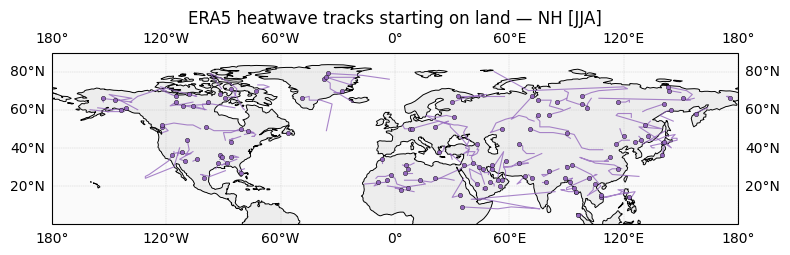

In [11]:
# Only tracks that *start* over land
fig, ax = plot_tracks_map(
    era5_df,#icon_df_2km, #era5_df,
    domain=domain,
    sufix=sufix,
    land_condition='start',  # this line does the trick
    epsilon_deg=0.02,
    color='tab:purple',
    lw=0.8,
    alpha=0.8
)
plt.show()

/tmp/ipykernel_21399/1647237798.py:24: DeprecationWarning: The 'shapely.vectorized.contains' function is deprecated and will be removed a future version. Use 'shapely.contains_xy' instead (available since shapely 2.0.0).
  return sv.contains(geom, lonw, lat)  # vectorized
/tmp/ipykernel_21399/1647237798.py:24: DeprecationWarning: The 'shapely.vectorized.contains' function is deprecated and will be removed a future version. Use 'shapely.contains_xy' instead (available since shapely 2.0.0).
  return sv.contains(geom, lonw, lat)  # vectorized
/tmp/ipykernel_21399/1647237798.py:24: DeprecationWarning: The 'shapely.vectorized.contains' function is deprecated and will be removed a future version. Use 'shapely.contains_xy' instead (available since shapely 2.0.0).
  return sv.contains(geom, lonw, lat)  # vectorized
/tmp/ipykernel_21399/1647237798.py:24: DeprecationWarning: The 'shapely.vectorized.contains' function is deprecated and will be removed a future version. Use 'shapely.contains_xy' i

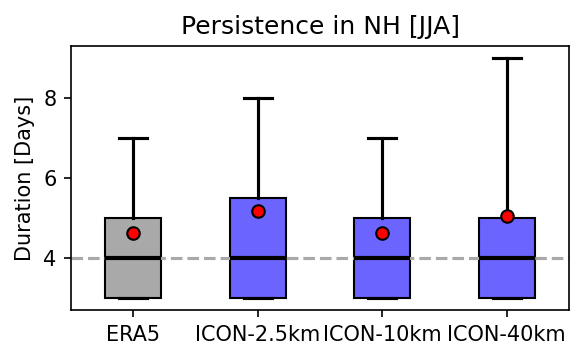

In [20]:
### persistence
#### Select domain and period
domain='NH' ### PAC, ATL, NH, SH
sufix='JJA' ### YEAR, DJF, JJA

if sufix == 'DJF':
    months = ['12', '01', '02']
elif sufix == 'JJA':
    months = ['06', '07', '08']
elif sufix == 'YEAR':
    months = ['01','02','03','04','05','06', '07', '08','09','10','11','12']
else:
    raise ValueError(f"Invalid season suffix: {sufix}")
    
# Get CSV files list from a folder
###ICON 2km
#file = '/capstor/scratch/cscs/edolores/EXCLAIM/ICON_2KM/Heatwaves/MA_TS/HW_ICON_NH_19592023_AMJJASO_daily_MA.csv'
file = '/capstor/scratch/cscs/edolores/EXCLAIM/ICON_2KM/Heatwaves/MA_TS/HW_ICON_NH_19592023_AMJJASO_daily_MA_simclim.csv'
icon_df_2km = pd.read_csv(file)
icon_df_2km['year']=icon_df_2km.Date.str[:4]
icon_df_2km['month']=icon_df_2km.Date.str[4:6]
icon_values_2km = icon_df_2km.groupby('Flag').size().reset_index(name='Duration')
icon_df_2km = icon_df_2km.merge(icon_values_2km, on='Flag', how='left')
### Select 5 years only
icon_df_2km = icon_df_2km[icon_df_2km['year'].isin( ['2020', '2021', '2022','2023'])]


###ICON 10km
#file = '/capstor/scratch/cscs/edolores/EXCLAIM/ICON_2KM/Heatwaves/MA_TS/HW_ICON_NH_19592023_AMJJASO_daily_MA.csv'
file = '/capstor/scratch/cscs/edolores/icon-climate-dt/Heatwaves/MA_TS/HW_ICON_NH_19592023_AMJJASO_daily_MA_simclim.csv'
icon_df_10km = pd.read_csv(file)
icon_df_10km['year']=icon_df_10km.Date.str[:4]
icon_df_10km['month']=icon_df_10km.Date.str[4:6]
icon_values_10km = icon_df_10km.groupby('Flag').size().reset_index(name='Duration')
icon_df_10km = icon_df_10km.merge(icon_values_10km, on='Flag', how='left')

###ICON 40km
#file = '/capstor/scratch/cscs/edolores/old_icon/Heatwaves/MA_TS/HW_ICON_NH_19592023_AMJJASO_daily_MA.csv'
file = '/capstor/scratch/cscs/edolores/old_icon/Heatwaves/MA_TS/HW_ICON_NH_19592023_AMJJASO_daily_MA_simclim.csv'
icon_df_40km = pd.read_csv(file)
icon_df_40km['year']=icon_df_40km.Date.str[:4]
icon_df_40km['month']=icon_df_40km.Date.str[4:6]
icon_values_40km = icon_df_40km.groupby('Flag').size().reset_index(name='Duration')
icon_df_40km = icon_df_40km.merge(icon_values_40km, on='Flag', how='left')

##ERA5
#file = '/capstor/scratch/cscs/edolores/OBS/ERA5/Heatwaves/MA_TS/HW_ERA5_NH_19592023_AMJJASO_daily_MA.csv'
file = '/capstor/scratch/cscs/edolores/OBS/ERA5/Heatwaves/MA_TS/HW_ERA5_NH_20202023_AMJJASO_daily_MA.csv'
era5_df = pd.read_csv(file)
era5_df['year']=era5_df.Date.str[:4]
era5_df['month']=era5_df.Date.str[4:6]
era5_values = era5_df.groupby('Flag').size().reset_index(name='Duration')
era5_df = era5_df.merge(era5_values, on='Flag', how='left')
### Select 5 years only
era5_df = era5_df[era5_df['year'].isin( ['2020', '2021', '2022','2023'])]

### filter domain
if domain == 'NH':
    icon_df_2km = icon_df_2km[(icon_df_2km['Latitude'] > 0 )]
    icon_df_10km = icon_df_10km[(icon_df_10km['Latitude'] > 0 )]
    icon_df_40km = icon_df_40km[(icon_df_40km['Latitude'] > 0 )]
    era5_df = era5_df[(era5_df['Latitude'] > 0 )]
if domain == 'ATL':
    icon_df_2km = icon_df_2km[(icon_df_2km['Latitude'] > 0 ) & (icon_df_2km['Longitude'] > -90 ) & (icon_df_2km['Longitude'] < 90 )]
    icon_df_10km = icon_df_10km[(icon_df_10km['Latitude'] > 0 ) & (icon_df_10km['Longitude'] > -90 ) & (icon_df_10km['Longitude'] < 90 )]
    icon_df_40km = icon_df_40km[(icon_df_40km['Latitude'] > 0 ) & (icon_df_40km['Longitude'] > -90 ) & (icon_df_40km['Longitude'] < 90 )]
    era5_df = era5_df[(era5_df['Latitude'] > 0)  & (era5_df['Longitude'] > -90 ) & (era5_df['Longitude'] < 90 )]
if domain == 'PAC':
    icon_df_2km = icon_df_2km[(icon_df_2km['Latitude'] > 0 ) & ((icon_df_2km['Longitude'] > 90 ) | (icon_df_2km['Longitude'] < -90 ))]
    icon_df_10km = icon_df_10km[(icon_df_10km['Latitude'] > 0 ) & ((icon_df_10km['Longitude'] > 90 ) | (icon_df_10km['Longitude'] < -90 ))]
    icon_df_40km = icon_df_40km[(icon_df_40km['Latitude'] > 0 ) & ((icon_df_40km['Longitude'] > 90 ) | (icon_df_40km['Longitude'] < -90 ))]
    era5_df = era5_df[(era5_df['Latitude'] > 0)  & ((era5_df['Longitude'] > 90) | (era5_df['Longitude'] < -90))]
if domain == 'SH':
    icon_df_2km = icon_df_2km[(icon_df_2km['Latitude'] < 0 )]
    icon_df_10km = icon_df_10km[(icon_df_10km['Latitude'] < 0 )]
    icon_df_40km = icon_df_40km[(icon_df_40km['Latitude'] < 0 )]
    era5_df = era5_df[(era5_df['Latitude'] < 0 )]

### select season
icon_df_2km = icon_df_2km[icon_df_2km['month'].isin(months)]
icon_df_10km = icon_df_10km[icon_df_10km['month'].isin(months)]
icon_df_40km = icon_df_40km[icon_df_40km['month'].isin(months)]
era5_df = era5_df[era5_df['month'].isin(months)]


# Color definitions
color_icon = '#6b64ff'
color_icon2 = '#6dcc4e'
color_era5 = 'darkgrey'
color_cmip6 = '#db6f30'

###################################
# Flag rows that lie on land
icon_df_2km['on_land'] = flag_land_rows(icon_df_2km, 'Longitude', 'Latitude', epsilon_deg=0.02)  # tweak epsilon if you want coastlines included
icon_df_10km['on_land'] = flag_land_rows(icon_df_10km, 'Longitude', 'Latitude', epsilon_deg=0.02)  # tweak epsilon if you want coastlines included
icon_df_40km['on_land'] = flag_land_rows(icon_df_40km, 'Longitude', 'Latitude', epsilon_deg=0.02)  # tweak epsilon if you want coastlines included
era5_df['on_land']     = flag_land_rows(era5_df, 'Longitude', 'Latitude', epsilon_deg=0.02)

# Find track IDs (Flags) that touch land at least once
#icon_flags_on_land = icon_df_2km.groupby('Flag')['on_land'].any()
#era5_flags_on_land = era5_df.groupby('Flag')['on_land'].any()
## first point
icon_flags_on_land = icon_df_2km.groupby('Flag')['on_land'].first()
icon_flags_on_land_10km = icon_df_10km.groupby('Flag')['on_land'].first()
icon_flags_on_land_40km = icon_df_40km.groupby('Flag')['on_land'].first()
era5_flags_on_land = era5_df.groupby('Flag')['on_land'].first()


# Keep only rows that belong to land-touching tracks
icon_df_2km_landtracks = icon_df_2km[ icon_df_2km['Flag'].isin(icon_flags_on_land[icon_flags_on_land].index) ]
icon_df_10km_landtracks = icon_df_10km[ icon_df_10km['Flag'].isin(icon_flags_on_land_10km[icon_flags_on_land_10km].index) ]
icon_df_40km_landtracks = icon_df_40km[ icon_df_40km['Flag'].isin(icon_flags_on_land_40km[icon_flags_on_land_40km].index) ]
era5_df_landtracks     = era5_df[     era5_df['Flag'].isin(era5_flags_on_land[era5_flags_on_land].index)     ]

# -------- Count tracks per year and plot (your code, with *_landtracks) --------
era5_values      = era5_df_landtracks.groupby('year')['Flag'].nunique().values
icon_values_2km  = icon_df_2km_landtracks.groupby('year')['Flag'].nunique().values
icon_values_10km  = icon_df_10km_landtracks.groupby('year')['Flag'].nunique().values
icon_values_40km  = icon_df_40km_landtracks.groupby('year')['Flag'].nunique().values

### keep only unique flags
icon_values_2km = icon_df_2km_landtracks.drop_duplicates(subset=['Flag']).reset_index(drop=True)
icon_values_10km = icon_df_10km_landtracks.drop_duplicates(subset=['Flag']).reset_index(drop=True)
icon_values_40km = icon_df_40km_landtracks.drop_duplicates(subset=['Flag']).reset_index(drop=True)
era5_values = era5_df_landtracks.drop_duplicates(subset=['Flag']).reset_index(drop=True)

###################################
# Sample DataFrame simulation
data = [era5_values['Duration'].values, icon_values_2km['Duration'].values, icon_values_10km['Duration'].values, icon_values_40km['Duration'].values]
labels = ['ERA5', 'ICON-2.5km', 'ICON-10km', 'ICON-40km']
colors = [color_era5, color_icon, color_icon, color_icon]

# Create a plot
###
fig, ax = plt.subplots(figsize=(4, 2.5), dpi=150)

# Boxplot configuration
boxprops = dict(facecolor='white', color='black')  # White box with black borders
medianprops = dict(color='black', linewidth=2)  # Median line
whiskerprops = dict(color='black', linewidth=1.5)  # Whiskers
capprops = dict(color='black', linewidth=1.5)  # Caps on whiskers

# Plot boxplot
bplot = ax.boxplot(data, patch_artist=True, labels=labels, 
                   boxprops=boxprops, medianprops=medianprops,whis=(10, 90),
                   whiskerprops=whiskerprops, capprops=capprops, showmeans=True, showfliers=False,
                   meanprops=dict(marker='o', markerfacecolor='red', markeredgecolor='black', markersize=6))

# Custom colors for boxes
for patch, color in zip(bplot['boxes'], colors):
    patch.set_facecolor(color)

# Calculate and add a horizontal line at the mean of era5_df
mean_era5 = np.median(era5_values['Duration'].values)
ax.axhline(mean_era5, color=color_era5, linestyle='--', linewidth=1.5, label=f'ERA5 Mean ({mean_era5:.2f})')


ax.set_ylabel('Duration [Days]')
ax.set_title('Persistence in '+domain+' ['+sufix+']')

plt.tight_layout()

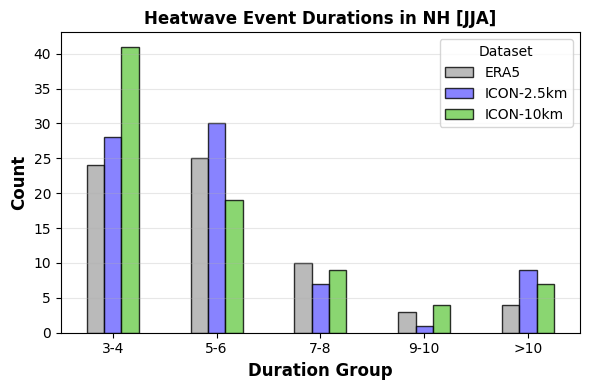

In [22]:
# Define bins and labels
#bins = [3, 6, 11, 16, 22, float('inf')]    #using era5 full climatology
#labels = ['3-6', '7-11', '12-16', '17-22', '>22']   #using era5 full climatology
bins = [3, 4, 6, 8, 10, float('inf')]
labels = ['3-4', '5-6', '7-8', '9-10', '>10']

# Apply binning to each dataset
era5_values['Duration Group'] = pd.cut(era5_values['Duration'], bins=bins, labels=labels, right=True)
icon_values_2km['Duration Group'] = pd.cut(icon_values_2km['Duration'], bins=bins, labels=labels, right=True)
icon_values_10km['Duration Group'] = pd.cut(icon_values_10km['Duration'], bins=bins, labels=labels, right=True)
icon_values_40km['Duration Group'] = pd.cut(icon_values_40km['Duration'], bins=bins, labels=labels, right=True)

# Count occurrences in each group
era5_counts = era5_values['Duration Group'].value_counts().sort_index()
icon_2km_counts = icon_values_2km['Duration Group'].value_counts().sort_index()
icon_10km_counts = icon_values_10km['Duration Group'].value_counts().sort_index()
icon_40km_counts = icon_values_40km['Duration Group'].value_counts().sort_index()


# Create a DataFrame to compare counts
#duration_df = pd.DataFrame({'ERA5': era5_counts, 'ICON-2km': icon_2km_counts, 'ICON-10km': icon_10km_counts, 'ICON-40km': icon_40km_counts}).fillna(0)
duration_df = pd.DataFrame({'ERA5': era5_counts, 'ICON-2.5km': icon_2km_counts, 'ICON-10km': icon_10km_counts}).fillna(0)

# Define hatching patterns (consistent for each dataset)
hatch_patterns = {'ERA5': None, 'ICON-2.5km': None,'ICON-10km': None} #,'ICON-40km': '\\'}#'IFS-9km': '/', 'IFS-28km': '\\'}

# Plot grouped bar chart
#ax = duration_df.plot(kind='bar', figsize=(6, 4),color=[color_era5, color_icon, color_icon2, color_icon], alpha=0.8, edgecolor='black')
ax = duration_df.plot(kind='bar', figsize=(6, 4),color=[color_era5, color_icon, color_icon2], alpha=0.8, edgecolor='black')

# Apply hatching consistently per dataset
for bar_container, dataset_name in zip(ax.containers, duration_df.columns):
    for bar in bar_container:
        bar.set_hatch(hatch_patterns[dataset_name])  # Apply consistent hatching

plt.title('Heatwave Event Durations in ' + domain + ' [' + sufix + ']', fontsize=12, weight="bold")
plt.xlabel('Duration Group', fontsize=12, weight="bold")
plt.ylabel('Count', fontsize=12, weight="bold")
plt.legend(title='Dataset')
plt.grid(axis='y', alpha=0.3)
plt.xticks(rotation=0)
plt.tight_layout()

plt.savefig(dir_figures+'Duration_PerBlob_byGroup_'+sufix+'_'+domain+'.jpg',dpi=300, facecolor='white', bbox_inches='tight', pad_inches=0)

In [19]:
era5_df

Flag         Date  Longitude  Latitude  Intensity        Size  year  \
52     1224  20200601_11       -136        22        1.0  4497083.61  2020   
53     1224  20200602_11       -136        21        1.0  5288524.82  2020   
54     1224  20200603_11       -132        21        1.0  7374621.22  2020   
55     1224  20200604_11       -123        23        1.0  5325193.36  2020   
56     1224  20200605_11       -132        19        1.0  5870825.87  2020   
...     ...          ...        ...       ...        ...         ...   ...   
1781  21953  20230827_11         19        43        1.0  1995126.69  2023   
1782  21953  20230828_11         26        46        1.0  1612533.02  2023   
1783  22129  20230829_11        137         3        1.0   242852.75  2023   
1784  22129  20230830_11        139         3        1.0   414917.94  2023   
1785  22129  20230831_11        140         3        1.0   571625.22  2023   

     month  Duration  on_land  
52      06        13    False  
53      06        13    False  
54      06        13    False  
55      06        13    False  
56      06        13    False  
...    ...       ...      ...  
1781    08         5     True  
1782    08         5     True  
1783    08         3    False  
1784    08         3    False  
1785    08         3    False  

[1377 rows x 10 columns]

In [10]:
icon_df_10km

Flag         Date  Longitude  Latitude  Intensity        Size  year  \
70     1093  20150601_00        110        23        1.0   571055.98  2015   
71     1093  20150602_00        110        23        1.0   565884.59  2015   
74     1097  20150601_00         41        32        1.0  1294262.83  2015   
75     1097  20150602_00         41        32        1.0  1492675.74  2015   
76     1097  20150603_00         40        31        1.0  2364930.65  2015   
...     ...          ...        ...       ...        ...         ...   ...   
2771  31266  20190830_00         12        49        1.0  2600805.82  2019   
2772  31266  20190831_00         16        50        1.0  2206238.61  2019   
2775  31280  20190830_00        303        77        1.0   922078.61  2019   
2776  31280  20190831_00        283        77        1.0   627323.61  2019   
2781  31285  20190831_00         61        10        1.0  5234203.70  2019   

     month  Duration  on_land  
70      06         4     True  
71      06         4     True  
74      06        10     True  
75      06        10     True  
76      06        10     True  
...    ...       ...      ...  
2771    08         4     True  
2772    08         4     True  
2775    08         6     True  
2776    08         6    False  
2781    08         3    False  

[1857 rows x 10 columns]